In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

import sys
import os

from pathlib import Path

parent = Path(os.path.abspath("")).resolve().parents[0]
if parent not in sys.path:
    sys.path.insert(0, str(parent))
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold

from catboost import CatBoostClassifier

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from utils.metrics import get_classification_metrics, get_probability_measures, get_lift_demotion_scores
import shap
shap.initjs()

In [2]:
def merge_strings_and_integers(val):
    try:
        return int(val)
    except:
        return 'other'

In [3]:
df = pd.read_csv("final_autof.csv")
df.drop(['MODE(consumptions.MS_METER_NBR)',
                #'MODE(consumptions.DAY(MEASUREMENT_DATE))',
         #'MODE(consumptions.MONTH(MEASUREMENT_DATE))',
                #'MODE(consumptions.WEEKDAY(MEASUREMENT_DATE))',
                'MODE(representations.SUPPLIER)',
                'MODE(representations.SUPPLIER_TO)',
               #'MODE(representations.DAY(END_DATE))',
                #'MODE(representations.MONTH(END_DATE))',
                #'MODE(representations.WEEKDAY(END_DATE))',
                #'MODE(representations.YEAR(END_DATE))',
                #'MODE(requests.DAY(REQUEST_DATE))',
       #'MODE(requests.MONTH(REQUEST_DATE))',
       #'MODE(requests.WEEKDAY(REQUEST_DATE))',
       #'MODE(requests.YEAR(REQUEST_DATE))',
                #'MODE(consumptions.BS_RATE)',
                #'NUM_UNIQUE(representations.MONTH(END_DATE))',
                #'NUM_UNIQUE(representations.SUPPLIER)'
               ], axis=1, inplace=True)
df.dropna(subset=['number_of_zeros'], inplace=True)


df['MODE(consumptions.BS_RATE)'] = df['MODE(consumptions.BS_RATE)'].apply(merge_strings_and_integers)
#transform_func = lambda x: x if x in [10, 11, 21] else 'other'
#df['MODE(consumptions.BS_RATE)'] = df['MODE(consumptions.BS_RATE)'].apply(transform_func)
df = df.drop(['rec_id'], axis=1)
df = df.drop_duplicates()
df['MODE(requests.REQUEST_TYPE)'] = df['MODE(requests.REQUEST_TYPE)'].replace(0, 'unknown')
df = pd.get_dummies(df, columns=['MODE(requests.REQUEST_TYPE)'], prefix='MODE(requests.REQUEST_TYPE)')
df = pd.get_dummies(df, columns=['MODE(consumptions.BS_RATE)'], prefix='MODE(consumptions.BS_RATE)')
df = df.drop(['voltage'], axis=1)
df.fillna(0, inplace=True)
df.head()

Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.


,COUNT(consumptions),MAX(consumptions.CSS_MS_HS_USE),MEAN(consumptions.CSS_MS_HS_USE),MIN(consumptions.CSS_MS_HS_USE),NUM_UNIQUE(consumptions.BS_RATE),NUM_UNIQUE(consumptions.MS_METER_NBR),SKEW(consumptions.CSS_MS_HS_USE),STD(consumptions.CSS_MS_HS_USE),SUM(consumptions.CSS_MS_HS_USE),MODE(consumptions.DAY(MEASUREMENT_DATE)),...,MODE(consumptions.BS_RATE)_40,MODE(consumptions.BS_RATE)_41,MODE(consumptions.BS_RATE)_42,MODE(consumptions.BS_RATE)_43,MODE(consumptions.BS_RATE)_44,MODE(consumptions.BS_RATE)_52,MODE(consumptions.BS_RATE)_53,MODE(consumptions.BS_RATE)_54,MODE(consumptions.BS_RATE)_55,MODE(consumptions.BS_RATE)_other
0,4.0,135.0,64.250000,12.0,1.0,1.0,0.758461,54.389797,257.0,2.0,...,0,0,0,0,0,0,0,0,0,0
1,10.0,127.0,51.900000,0.0,1.0,2.0,0.783315,43.072162,519.0,2.0,...,0,0,0,0,0,0,0,0,0,0
2,12.0,6068.0,3924.166667,2446.0,1.0,1.0,0.574519,1012.516472,47090.0,28.0,...,0,0,0,0,0,0,0,0,0,0
3,6.0,1061.0,479.333333,7.0,2.0,1.0,0.020392,409.340282,2876.0,4.0,...,0,0,0,0,0,0,0,0,0,0
4,24.0,1247.0,536.833333,0.0,2.0,1.0,0.537625,335.364392,12884.0,4.0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
'''df = df.drop(['MODE(consumptions.BS_RATE)_55',
             'MODE(consumptions.BS_RATE)_54',
             'MODE(consumptions.BS_RATE)_36',
             'MODE(consumptions.BS_RATE)_6',
             'MODE(requests.REQUEST_TYPE)_unknown',
             'MODE(requests.REQUEST_TYPE)_unknown',
             'NUM_UNIQUE(representations.SUPPLIER)',
             'MODE(consumptions.BS_RATE)_33',
             'MODE(consumptions.BS_RATE)_43', 
             'MODE(consumptions.BS_RATE)_44',
             #'MODE(consumptions.BS_RATE)_52',
             #'MODE(consumptions.BS_RATE)_41',
             #'MODE(consumptions.BS_RATE)_25',
             #'MODE(consumptions.BS_RATE)_23',
             #'MODE(consumptions.BS_RATE)_24',
             #'NUM_UNIQUE(representations.MONTH(END_DATE))',
             #'MODE(consumptions.BS_RATE)_53',
             #'NUM_UNIQUE(representations.YEAR(END_DATE))',
             #'MODE(consumptions.BS_RATE)_40',
             #'MODE(consumptions.BS_RATE)_42',
             #'NUM_UNIQUE(representations.DAY(END_DATE))',
             #'COUNT(representations)',
             #'MODE(consumptions.BS_RATE)_22',
              #'MODE(consumptions.BS_RATE)_15',
              #'MODE(consumptions.BS_RATE)_13',
              #'MODE(consumptions.BS_RATE)_11',
              #'MODE(consumptions.BS_RATE)_12',
              #'NUM_UNIQUE(representations.WEEKDAY(END_DATE))',
              #'MODE(consumptions.BS_RATE)_14',
              #'MODE(consumptions.BS_RATE)_37',
              #'MODE(consumptions.BS_RATE)_21'
             ], axis=1)'''


"df = df.drop(['MODE(consumptions.BS_RATE)_55',\n             'MODE(consumptions.BS_RATE)_54',\n             'MODE(consumptions.BS_RATE)_36',\n             'MODE(consumptions.BS_RATE)_6',\n             'MODE(requests.REQUEST_TYPE)_unknown',\n             'MODE(requests.REQUEST_TYPE)_unknown',\n             'NUM_UNIQUE(representations.SUPPLIER)',\n             'MODE(consumptions.BS_RATE)_33',\n             'MODE(consumptions.BS_RATE)_43', \n             'MODE(consumptions.BS_RATE)_44',\n             #'MODE(consumptions.BS_RATE)_52',\n             #'MODE(consumptions.BS_RATE)_41',\n             #'MODE(consumptions.BS_RATE)_25',\n             #'MODE(consumptions.BS_RATE)_23',\n             #'MODE(consumptions.BS_RATE)_24',\n             #'NUM_UNIQUE(representations.MONTH(END_DATE))',\n             #'MODE(consumptions.BS_RATE)_53',\n             #'NUM_UNIQUE(representations.YEAR(END_DATE))',\n             #'MODE(consumptions.BS_RATE)_40',\n             #'MODE(consumptions.BS_RATE)_42',\n  

In [5]:
encodings = pd.read_csv('000.autoencoder_classifier_encoded.csv')

df.reset_index(drop=True, inplace=True)
encodings.reset_index(drop=True, inplace=True)
df = df.join(encodings)
print(len(df))
df = df.drop_duplicates()
print(len(df))
df.head()

700519
700519


,COUNT(consumptions),MAX(consumptions.CSS_MS_HS_USE),MEAN(consumptions.CSS_MS_HS_USE),MIN(consumptions.CSS_MS_HS_USE),NUM_UNIQUE(consumptions.BS_RATE),NUM_UNIQUE(consumptions.MS_METER_NBR),SKEW(consumptions.CSS_MS_HS_USE),STD(consumptions.CSS_MS_HS_USE),SUM(consumptions.CSS_MS_HS_USE),MODE(consumptions.DAY(MEASUREMENT_DATE)),...,t_hidden_23,t_hidden_24,t_hidden_25,t_hidden_26,t_hidden_27,t_hidden_28,t_hidden_29,t_hidden_30,t_hidden_31,t_hidden_32
0,4.0,135.0,64.250000,12.0,1.0,1.0,0.758461,54.389797,257.0,2.0,...,-0.200738,1.677683,1.607058,-0.097354,-0.945015,0.023192,-0.231664,-0.234937,-0.792697,-1.055135
1,10.0,127.0,51.900000,0.0,1.0,2.0,0.783315,43.072162,519.0,2.0,...,0.234075,1.257790,1.099965,0.268211,-0.205435,-0.297397,-0.193492,-0.355553,-0.878955,-0.729695
2,12.0,6068.0,3924.166667,2446.0,1.0,1.0,0.574519,1012.516472,47090.0,28.0,...,-0.062386,1.726098,1.359127,-0.246991,-0.710691,0.044353,-1.086494,-0.080327,0.226533,-0.637788
3,6.0,1061.0,479.333333,7.0,2.0,1.0,0.020392,409.340282,2876.0,4.0,...,-0.077913,0.708339,1.308034,-0.366745,-0.736609,-0.246300,0.084537,-1.052447,-0.190187,-0.436573
4,24.0,1247.0,536.833333,0.0,2.0,1.0,0.537625,335.364392,12884.0,4.0,...,-0.365520,0.304948,1.052117,0.060189,-0.703044,0.253437,-0.312321,-0.626512,-0.150037,-0.063584


In [6]:
thefts = df.loc[df.target==1]

In [7]:
thefts.head()

,COUNT(consumptions),MAX(consumptions.CSS_MS_HS_USE),MEAN(consumptions.CSS_MS_HS_USE),MIN(consumptions.CSS_MS_HS_USE),NUM_UNIQUE(consumptions.BS_RATE),NUM_UNIQUE(consumptions.MS_METER_NBR),SKEW(consumptions.CSS_MS_HS_USE),STD(consumptions.CSS_MS_HS_USE),SUM(consumptions.CSS_MS_HS_USE),MODE(consumptions.DAY(MEASUREMENT_DATE)),...,t_hidden_23,t_hidden_24,t_hidden_25,t_hidden_26,t_hidden_27,t_hidden_28,t_hidden_29,t_hidden_30,t_hidden_31,t_hidden_32
51,13.0,2328.0,868.076923,0.0,1.0,2.0,0.882241,753.713856,11285.0,1.0,...,-1.128317,0.246413,-0.015033,0.240943,-0.201575,-0.253183,-0.250245,-0.839157,0.074264,0.294829
1069,13.0,2523.0,854.230769,0.0,1.0,1.0,0.610802,771.960616,11105.0,16.0,...,-0.597781,0.724960,1.360308,0.169271,-1.438661,0.602834,-0.472740,-0.827459,-0.197298,-0.670905
1362,10.0,0.0,0.000000,0.0,2.0,1.0,0.000000,0.000000,0.0,27.0,...,-0.972996,-0.749214,0.444900,0.292745,-0.611912,0.157436,-0.181220,-1.294232,0.319026,0.491615
1436,7.0,1851.0,810.000000,0.0,1.0,2.0,0.394506,754.945473,5670.0,24.0,...,-0.423448,0.499428,0.615793,0.308977,-0.367781,-0.252300,0.116428,-0.731475,0.508653,-0.561184
3203,18.0,1509.0,607.777778,0.0,2.0,1.0,0.524861,429.797292,10940.0,1.0,...,-0.393889,0.802297,1.793266,-0.230931,-1.283046,0.184046,-0.212629,-1.126103,-0.747505,-1.180040


In [8]:
non_thefts = df.loc[df.target==0]
non_thefts.head()

,COUNT(consumptions),MAX(consumptions.CSS_MS_HS_USE),MEAN(consumptions.CSS_MS_HS_USE),MIN(consumptions.CSS_MS_HS_USE),NUM_UNIQUE(consumptions.BS_RATE),NUM_UNIQUE(consumptions.MS_METER_NBR),SKEW(consumptions.CSS_MS_HS_USE),STD(consumptions.CSS_MS_HS_USE),SUM(consumptions.CSS_MS_HS_USE),MODE(consumptions.DAY(MEASUREMENT_DATE)),...,t_hidden_23,t_hidden_24,t_hidden_25,t_hidden_26,t_hidden_27,t_hidden_28,t_hidden_29,t_hidden_30,t_hidden_31,t_hidden_32
0,4.0,135.0,64.250000,12.0,1.0,1.0,0.758461,54.389797,257.0,2.0,...,-0.200738,1.677683,1.607058,-0.097354,-0.945015,0.023192,-0.231664,-0.234937,-0.792697,-1.055135
1,10.0,127.0,51.900000,0.0,1.0,2.0,0.783315,43.072162,519.0,2.0,...,0.234075,1.257790,1.099965,0.268211,-0.205435,-0.297397,-0.193492,-0.355553,-0.878955,-0.729695
2,12.0,6068.0,3924.166667,2446.0,1.0,1.0,0.574519,1012.516472,47090.0,28.0,...,-0.062386,1.726098,1.359127,-0.246991,-0.710691,0.044353,-1.086494,-0.080327,0.226533,-0.637788
3,6.0,1061.0,479.333333,7.0,2.0,1.0,0.020392,409.340282,2876.0,4.0,...,-0.077913,0.708339,1.308034,-0.366745,-0.736609,-0.246300,0.084537,-1.052447,-0.190187,-0.436573
4,24.0,1247.0,536.833333,0.0,2.0,1.0,0.537625,335.364392,12884.0,4.0,...,-0.365520,0.304948,1.052117,0.060189,-0.703044,0.253437,-0.312321,-0.626512,-0.150037,-0.063584


In [9]:
for i, col in enumerate(thefts.columns):
    
    print("col:", col)
    print("--"*1)
    print("THEFTS:")
    print(f"min={thefts[col].min()}, max={thefts[col].max()}, mean={thefts[col].mean()}")
    print(f"mode={thefts[col].mode()[0]}, kurtosis={thefts[col].kurtosis()}, skew={thefts[col].skew()}")
    print("")
    print("NON-THEFTS:")
    print(f"min={non_thefts[col].min()}, max={non_thefts[col].max()}, mean={non_thefts[col].mean()}")
    print(f"mode={non_thefts[col].mode()[0]}, kurtosis={non_thefts[col].kurtosis()}, skew={non_thefts[col].skew()}")
    print("--"*1)
    continue
    
    fig, ax = plt.subplots(ncols=2, figsize=(10, 5),)
    
    sns.histplot(thefts[col], kde=True, ax=ax[0], label=f'Thefts', stat='density')
    sns.histplot(non_thefts[col], kde=True, ax=ax[1], label=f'NonThefts', stat='density')
    
    x_axis = np.linspace(thefts[col].min(), thefts[col].max(), 100)
    ax[0].plot(x_axis, norm.pdf(x_axis, thefts[col].mean(), thefts[col].std()), label='Normal Distribution', color='red')
    ax[1].plot(x_axis, norm.pdf(x_axis, non_thefts[col].mean(), non_thefts[col].std()), label='Normal Distribution', color='red')
    
    ax[0].legend()
    ax[1].legend()
    plt.tight_layout()
    plt.show()
    plt.close()

col: COUNT(consumptions)
--
THEFTS:
min=1.0, max=114.0, mean=12.473582474226804
mode=10.0, kurtosis=28.826774542722895, skew=3.7307841762317877

NON-THEFTS:
min=1.0, max=117.0, mean=12.94368260590271
mode=14.0, kurtosis=19.403132719448454, skew=2.5135616219109247
--
col: MAX(consumptions.CSS_MS_HS_USE)
--
THEFTS:
min=0.0, max=182227.0, mean=4095.736469072165
mode=0.0, kurtosis=93.74455248053528, skew=8.33757081444466

NON-THEFTS:
min=0.0, max=3705840.0, mean=2324.837411494391
mode=0.0, kurtosis=64094.29943424564, skew=206.09327390955443
--
col: MEAN(consumptions.CSS_MS_HS_USE)
--
THEFTS:
min=0.0, max=50101.25, mean=1260.2224680766901
mode=0.0, kurtosis=105.7735580744324, skew=8.58741434569547

NON-THEFTS:
min=0.0, max=999964.5, mean=955.232701767821
mode=0.0, kurtosis=53121.064839555685, skew=147.3996259888369
--
col: MIN(consumptions.CSS_MS_HS_USE)
--
THEFTS:
min=0.0, max=16976.0, mean=128.8659793814433
mode=0.0, kurtosis=273.8287463145959, skew=14.399078729494542

NON-THEFTS:
min=0.0

mode=0.0, kurtosis=5.675134073403587, skew=2.103356472594791
--
col: NUM_UNIQUE(requests.YEAR(REQUEST_DATE))
--
THEFTS:
min=0.0, max=5.0, mean=1.3086340206185567
mode=1.0, kurtosis=1.3067464634525705, skew=0.9001737397749914

NON-THEFTS:
min=0.0, max=5.0, mean=0.49891196580096053
mode=0.0, kurtosis=3.35543234049967, skew=1.5325480092863488
--
col: number_of_measurements
--
THEFTS:
min=1.0, max=57.0, mean=8.929123711340207
mode=5.0, kurtosis=20.751375859311487, skew=3.3494634467607214

NON-THEFTS:
min=1.0, max=59.0, mean=8.993511853921573
mode=13.0, kurtosis=16.839414379295036, skew=2.361900094788735
--
col: number_of_zeros
--
THEFTS:
min=0.0, max=16.0, mean=1.1527061855670102
mode=0.0, kurtosis=9.79224605744991, skew=2.8664333317661

NON-THEFTS:
min=0.0, max=57.0, mean=0.30685139641785664
mode=0.0, kurtosis=90.70695688257433, skew=7.358626422286924
--
col: max_energy_per_day
--
THEFTS:
min=0.0, max=8665.0, mean=61.55819193654904
mode=0.0, kurtosis=347.88103441594654, skew=16.8931192504

mode=0, kurtosis=69892.19998969928, skew=264.3747340472903
--
col: MODE(consumptions.BS_RATE)_40
--
THEFTS:
min=0, max=1, mean=0.003865979381443299
mode=0, kurtosis=254.49356093872603, skew=16.005174372939237

NON-THEFTS:
min=0, max=1, mean=0.0020387228581606855
mode=0, kurtosis=485.50868240398665, skew=22.07956732334767
--
col: MODE(consumptions.BS_RATE)_41
--
THEFTS:
min=0, max=1, mean=0.001288659793814433
mode=0, kurtosis=773.4948362122789, skew=27.829805341569834

NON-THEFTS:
min=0, max=1, mean=0.00031331951293837905
mode=0, kurtosis=3186.653254390973, skew=56.46808068468035
--
col: MODE(consumptions.BS_RATE)_42
--
THEFTS:
min=0, max=0, mean=0.0
mode=0, kurtosis=0, skew=0

NON-THEFTS:
min=0, max=1, mean=1.4306827074811829e-06
mode=0, kurtosis=698967.0000000009, skew=836.0424630364187
--
col: MODE(consumptions.BS_RATE)_43
--
THEFTS:
min=0, max=0, mean=0.0
mode=0, kurtosis=0, skew=0

NON-THEFTS:
min=0, max=1, mean=0.00013591485721071238
mode=0, kurtosis=7352.600109022279, skew=85.758

mode=0.037903469055891, kurtosis=11.42946363712894, skew=1.530396895891257
--
col: t_hidden_18
--
THEFTS:
min=-2.129643440246582, max=2.1616780757904053, mean=0.10181989325642508
mode=-2.129643440246582, kurtosis=1.8698831390926336, skew=-0.7345999500658805

NON-THEFTS:
min=-5.3704376220703125, max=4.448713779449463, mean=-0.4320591356002997
mode=-1.1579900979995728, kurtosis=-0.36225795905415437, skew=-0.4630178400410673
--
col: t_hidden_19
--
THEFTS:
min=-2.349630832672119, max=2.3567802906036377, mean=0.12497862244802575
mode=-2.349630832672119, kurtosis=0.17981037302967628, skew=-0.5129992399490874

NON-THEFTS:
min=-9.38312816619873, max=29.6749324798584, mean=0.9169962046672013
mode=0.9038098454475404, kurtosis=36.025228471213765, skew=4.399085130658522
--
col: t_hidden_20
--
THEFTS:
min=-2.631483554840088, max=1.9762024879455569, mean=-0.049546726919307386
mode=-2.631483554840088, kurtosis=0.29066599527040893, skew=-0.5231052827577617

NON-THEFTS:
min=-15.646906852722168, max=7.7

In [10]:
def plot_dist(thefts, non_thefts, col):
    print("col:", col)
    print("--"*1)
    print("THEFTS:")
    print(f"min={thefts[col].min()}, max={thefts[col].max()}, mean={thefts[col].mean()}")
    print(f"mode={thefts[col].mode()[0]}, kurtosis={thefts[col].kurtosis()}, skew={thefts[col].skew()}")
    print("")
    print("NON-THEFTS:")
    print(f"min={non_thefts[col].min()}, max={non_thefts[col].max()}, mean={non_thefts[col].mean()}")
    print(f"mode={non_thefts[col].mode()[0]}, kurtosis={non_thefts[col].kurtosis()}, skew={non_thefts[col].skew()}")
    print("--"*1)
    fig, ax = plt.subplots(ncols=2, figsize=(10, 5),)
    
    sns.histplot(thefts[col], kde=True, ax=ax[0], label=f'Thefts', stat='density')
    sns.histplot(non_thefts[col], kde=True, ax=ax[1], label=f'NonThefts', stat='density')
    
    x_axis = np.linspace(thefts[col].min(), thefts[col].max(), 100)
    ax[0].plot(x_axis, norm.pdf(x_axis, thefts[col].mean(), thefts[col].std()), label='Normal Distribution', color='red')
    ax[1].plot(x_axis, norm.pdf(x_axis, non_thefts[col].mean(), non_thefts[col].std()), label='Normal Distribution', color='red')
    
    ax[0].legend()
    ax[1].legend()
    plt.tight_layout()
    plt.show()
    plt.close()

In [11]:
def train(clf, X, y, cols):
    #for clf_name, clf in clfs.items():
    # Initialize the evaluation metrics lists
    acc_scores = []
    prec_scores = []
    rec_scores = []
    f1_scores = []
    brier_scores, auc_roc_scores, pr_auc_scores = [], [], []
    lift_scores, demotion_scores, weighted_scores = [], [], []
    scaler = MinMaxScaler()
    print("Classifier: CATBOOST")
    assert len(X) == len(y)
    print("Number of samples:", len(X))
    print("Data bins", np.bincount(y))

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        
        
        print("bins", np.bincount(y_train))
        print("bins", np.bincount(y_test))

        #if clf_name == "CatBoost":
        clf.fit(X_train, y_train, verbose=False)

        #else:
        #clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)

        acc, precision, recall, f1 = get_classification_metrics(y_test.values, y_pred)

        y_scores = clf.predict_proba(X_test)
        idx = np.argmax(y_scores, axis=1)
        y_scores = np.where(idx == 0, 1 - y_scores[:, 0], y_scores[:, 1])


        brier, roc_auc, pr_auc = get_probability_measures(y_test.values, y_scores)

        num_ones = np.sum(y_test == 1)


        s1 = int(0.1 * num_ones)
        s2 = int(0.2 * num_ones)
        s3 = int(0.3 * num_ones)
        s4 = int(0.4 * num_ones)
        s5 = int(0.5 * num_ones)
        s6 = int(0.6 * num_ones)
        s7 = int(0.7 * num_ones)
        s8 = int(0.8 * num_ones)
        s9 = int(0.9 * num_ones)
        s10 = int(1 * num_ones)

        lift1, demotion1, weighted_score1 = get_lift_demotion_scores(y_test.values, y_scores,
                                                                    num_samples=s1)
        lift2, demotion2, weighted_score2 = get_lift_demotion_scores(y_test.values, y_scores,
                                                                    num_samples=s2)
        lift3, demotion3, weighted_score3 = get_lift_demotion_scores(y_test.values, y_scores,
                                                                    num_samples=s3)
        lift4, demotion4, weighted_score4 = get_lift_demotion_scores(y_test.values, y_scores,
                                                                    num_samples=s4)
        lift5, demotion5, weighted_score5 = get_lift_demotion_scores(y_test.values, y_scores,
                                                                    num_samples=s5)
        lift6, demotion6, weighted_score6 = get_lift_demotion_scores(y_test.values, y_scores,
                                                                    num_samples=s6)
        lift7, demotion7, weighted_score7 = get_lift_demotion_scores(y_test.values, y_scores,
                                                                    num_samples=s7)
        lift8, demotion8, weighted_score8 = get_lift_demotion_scores(y_test.values, y_scores,
                                                                    num_samples=s8)
        lift9, demotion9, weighted_score9 = get_lift_demotion_scores(y_test.values, y_scores,
                                                                    num_samples=s9)
        lift10, demotion10, weighted_score10 = get_lift_demotion_scores(y_test.values, y_scores,
                                                                    num_samples=s10)

        acc_scores.append(acc)
        prec_scores.append(precision)
        rec_scores.append(recall)
        f1_scores.append(f1)

        brier_scores.append(brier)
        auc_roc_scores.append(roc_auc)
        pr_auc_scores.append(pr_auc)

        lift_scores.append(lift4)
        demotion_scores.append(demotion4)
        weighted_scores.append(weighted_score4)

        print(f"0.1 -- Lift: {lift1:.4f}, Demotion: {demotion1:.4f}, Weighted: {weighted_score1:.4f}")
        print(f"0.2 -- Lift: {lift2:.4f}, Demotion: {demotion2:.4f}, Weighted: {weighted_score2:.4f}")
        print(f"0.3 -- Lift: {lift3:.4f}, Demotion: {demotion3:.4f}, Weighted: {weighted_score3:.4f}")
        print(f"0.4 -- Lift: {lift4:.4f}, Demotion: {demotion4:.4f}, Weighted: {weighted_score4:.4f}")
        print(f"0.5 -- Lift: {lift5:.4f}, Demotion: {demotion5:.4f}, Weighted: {weighted_score5:.4f}")
        print(f"0.6 -- Lift: {lift6:.4f}, Demotion: {demotion6:.4f}, Weighted: {weighted_score6:.4f}")
        print(f"0.7 -- Lift: {lift7:.4f}, Demotion: {demotion7:.4f}, Weighted: {weighted_score7:.4f}")
        print(f"0.8 -- Lift: {lift8:.4f}, Demotion: {demotion8:.4f}, Weighted: {weighted_score8:.4f}")
        print(f"0.9 -- Lift: {lift9:.4f}, Demotion: {demotion9:.4f}, Weighted: {weighted_score9:.4f}")
        print(f"1 -- Lift: {lift10:.4f}, Demotion: {demotion10:.4f}, Weighted: {weighted_score10:.4f}")

        print("Fold {} - Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}, Brier: {:.4f}, AUC-ROC: {:.4f}, PR-AUC: {:.4f}, Lift: {:.4f}, Demotion: {:.4f}, Weighted: {:.4f}"
                .format(len(acc_scores), acc_scores[-1], prec_scores[-1], rec_scores[-1], f1_scores[-1],
                        brier_scores[-1], auc_roc_scores[-1], pr_auc_scores[-1],
                        lift_scores[-1], demotion_scores[-1], weighted_scores[-1]))
        
    
    print("Average - Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}, Brier: {:.4f}, AUC-ROC: {:.4f}, PR-AUC: {:.4f}, Lift: {:.4f}, Demotion: {:.4f}, Weighted: {:.4f}\n"
            .format(sum(acc_scores)/len(acc_scores), sum(prec_scores)/len(prec_scores),
                    sum(rec_scores)/len(rec_scores), sum(f1_scores)/len(f1_scores),
                    sum(brier_scores)/len(brier_scores), sum(auc_roc_scores)/len(auc_roc_scores), sum(pr_auc_scores)/len(pr_auc_scores),
                    sum(lift_scores)/len(lift_scores), sum(demotion_scores)/len(demotion_scores), sum(weighted_scores)/len(weighted_scores)))
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test, plot_type='bar', max_display=len(cols), feature_names=cols, show=False)
    plt.tight_layout()
    plt.show()
    plt.close()


In [11]:
clf = CatBoostClassifier(random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [12]:
def cap_values(df, col, percentile=0.9, val=None):
    df = df.copy()
    if val is None:
        cap_val = df[col].quantile(percentile)
    else:
        cap_val = val
    print("cap =", cap_val)
    df[col] = df[col].clip(upper=cap_val)
    return df, cap_val

In [13]:
#print(len(df))
#df = df.drop_duplicates()
#print(len(df))

#X = df.drop(['target'], axis=1)
#y = df['target']
#train(clf, X, y, list(df.columns))

col: auto_loss
--
THEFTS:
min=0.01113286241889, max=9.507417678833008, mean=4.366092506122833
mode=0.01113286241889, kurtosis=0.07482189091964608, skew=-0.13732756449960087

NON-THEFTS:
min=7.366862701019272e-05, max=1.9887099266052248, mean=0.0019538435899628345
mode=7.366862701019272e-05, kurtosis=7679.1645581208595, skew=62.58133043663151
--


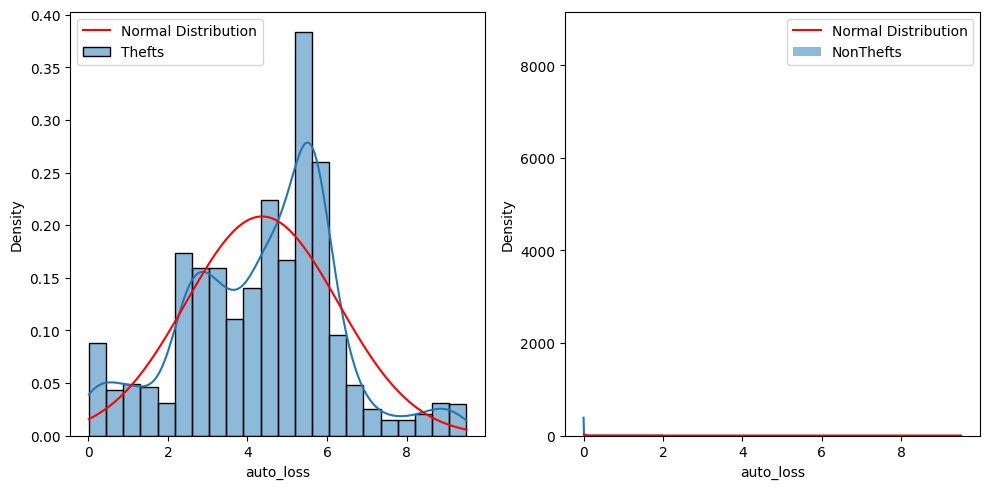

col: t_hidden_1
--
THEFTS:
min=-3.8097236156463614, max=1.8952932357788088, mean=-0.6598600149496708
mode=-3.8097236156463614, kurtosis=0.806851426024981, skew=-0.036354911363938036

NON-THEFTS:
min=-8.733851432800293, max=4.653857231140137, mean=0.12126000137668409
mode=1.014029026031494, kurtosis=-0.5796103447217154, skew=-0.14383933340836996
--


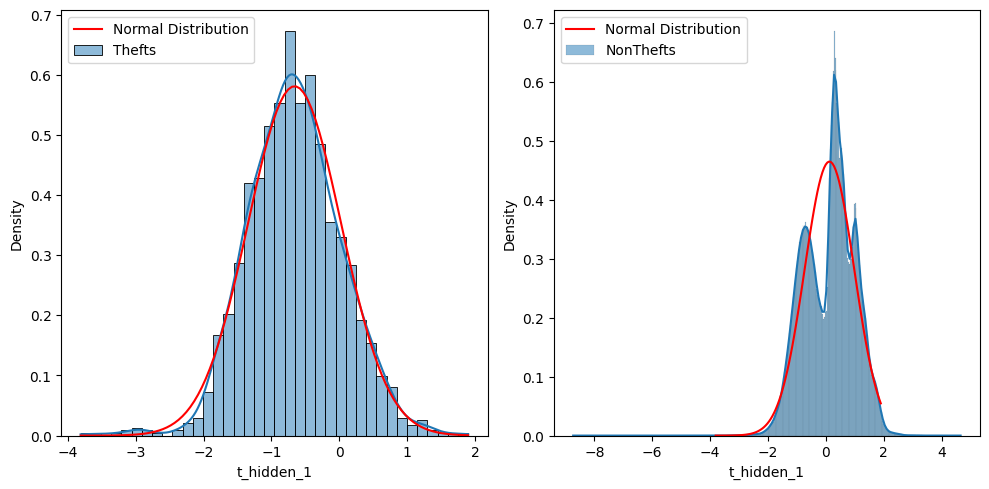

col: t_hidden_2
--
THEFTS:
min=-1.8334826231002808, max=1.868369579315185, mean=-0.11385153462034986
mode=-1.8334826231002808, kurtosis=0.5119800313567962, skew=0.6086006428596819

NON-THEFTS:
min=-1.8745923042297363, max=4.84242057800293, mean=0.5112967136928208
mode=1.5553966760635376, kurtosis=-0.9886139044881834, skew=-0.21650459038133119
--


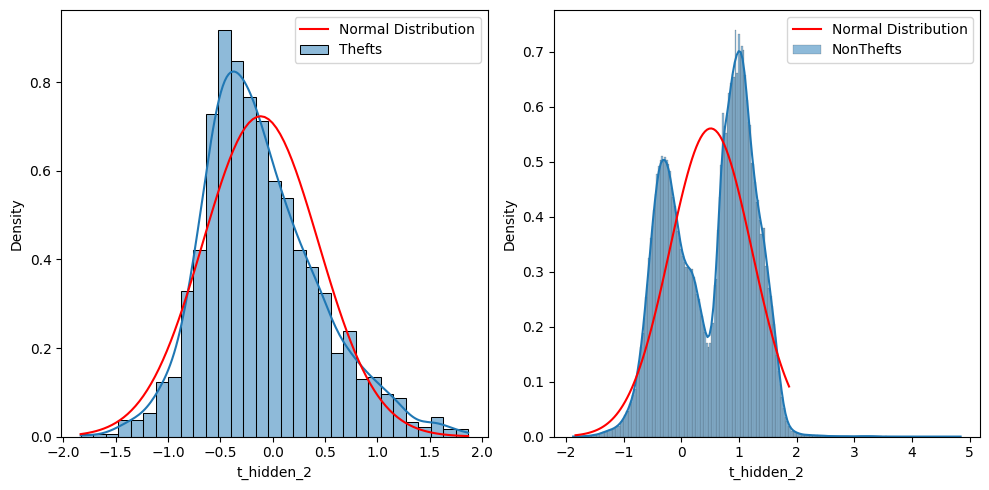

col: t_hidden_3
--
THEFTS:
min=-1.0316193103790283, max=2.914304733276367, mean=0.29004216894324986
mode=-1.0316193103790283, kurtosis=2.3773515324187193, skew=0.8883993867705342

NON-THEFTS:
min=-1.4808306694030762, max=4.632432460784912, mean=-0.13221924916211705
mode=-0.8173689246177673, kurtosis=1.6870114205155837, skew=1.0392163781678396
--


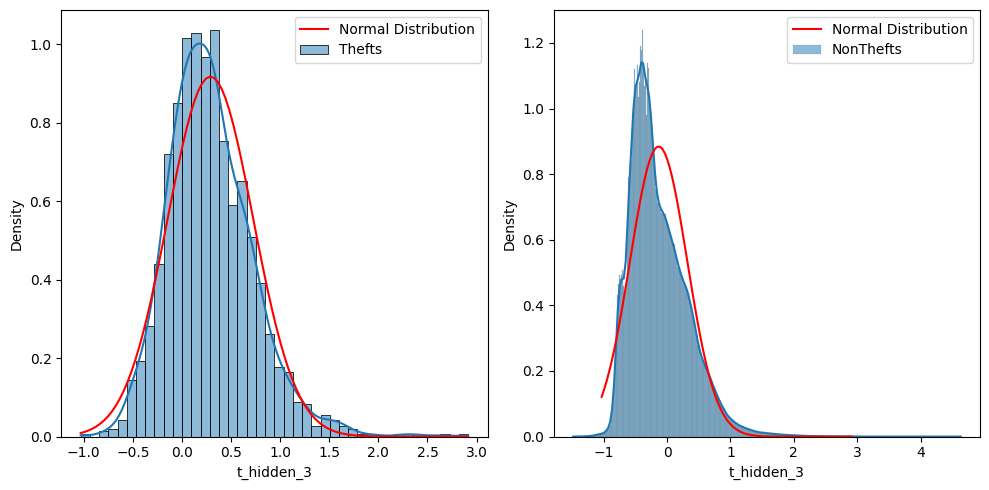

col: t_hidden_4
--
THEFTS:
min=-4.245906352996826, max=1.743669509887695, mean=-0.3413207770190826
mode=-4.245906352996826, kurtosis=0.6538882781584987, skew=-0.3484844703774332

NON-THEFTS:
min=-8.260175704956055, max=23.775909423828125, mean=0.7735842612234378
mode=0.3759837746620178, kurtosis=5.05309781385801, skew=0.5343553221578086
--


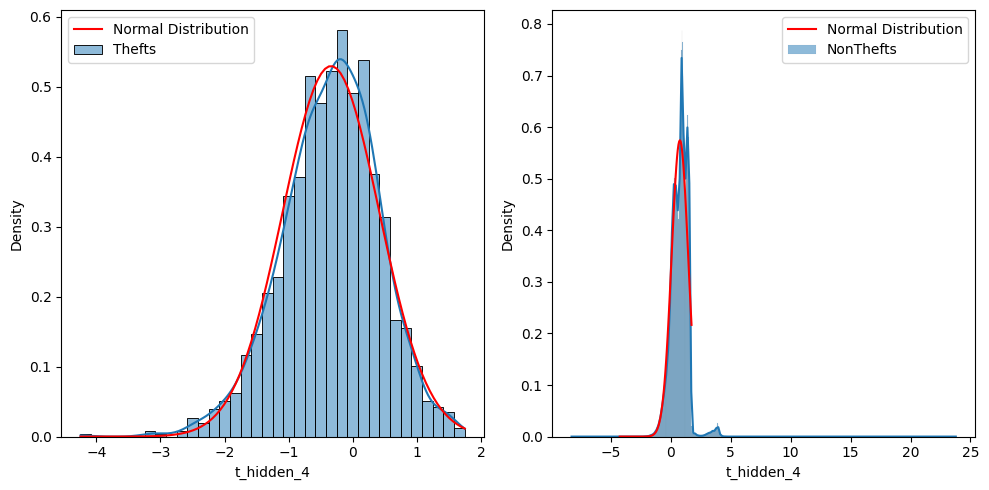

col: t_hidden_5
--
THEFTS:
min=-2.261686325073242, max=2.708057403564453, mean=-0.2425229308512254
mode=-2.261686325073242, kurtosis=0.5803081225416546, skew=0.38520212964029965

NON-THEFTS:
min=-6.086620330810547, max=2.191627264022827, mean=-0.4679145408167774
mode=-0.0345284789800643, kurtosis=0.8718959976204066, skew=-0.553018541753102
--


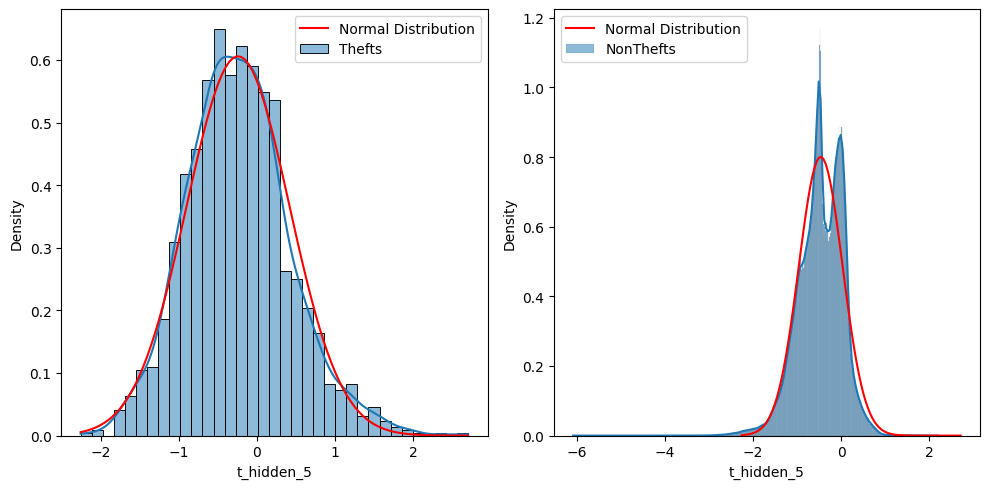

col: t_hidden_6
--
THEFTS:
min=-1.2970197200775146, max=4.574138641357422, mean=1.1158565902439206
mode=-1.2970197200775146, kurtosis=0.4333615081366142, skew=0.6150032718730865

NON-THEFTS:
min=-1.571643590927124, max=17.954803466796875, mean=0.9144138756425109
mode=0.2707820236682892, kurtosis=6.160297768759696, skew=1.7363314748733527
--


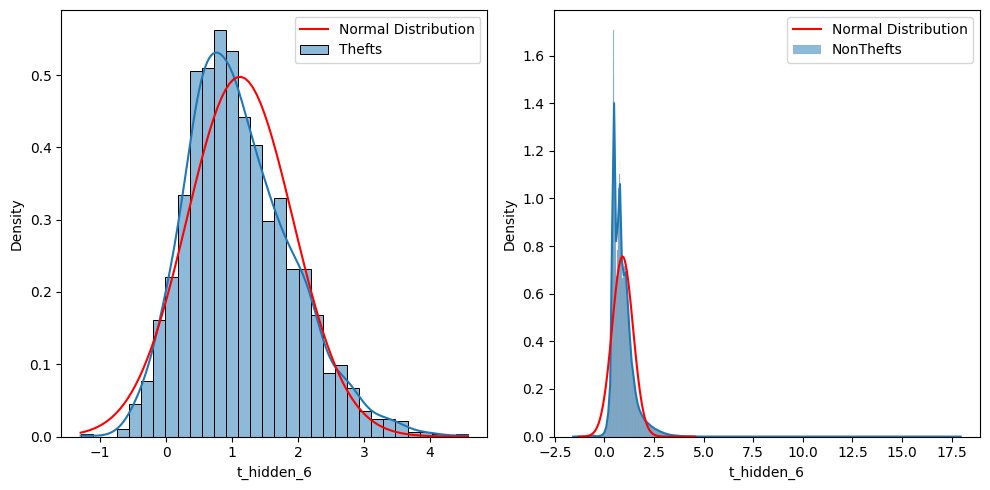

col: t_hidden_7
--
THEFTS:
min=-2.43953013420105, max=1.976166009902954, mean=-0.47308032524282323
mode=-2.43953013420105, kurtosis=0.47517905113831693, skew=0.1577309510489265

NON-THEFTS:
min=-15.68741512298584, max=1.004727482795715, mean=-0.6641395077113537
mode=-0.1520968079566955, kurtosis=11.169361134208508, skew=-2.140822454387275
--


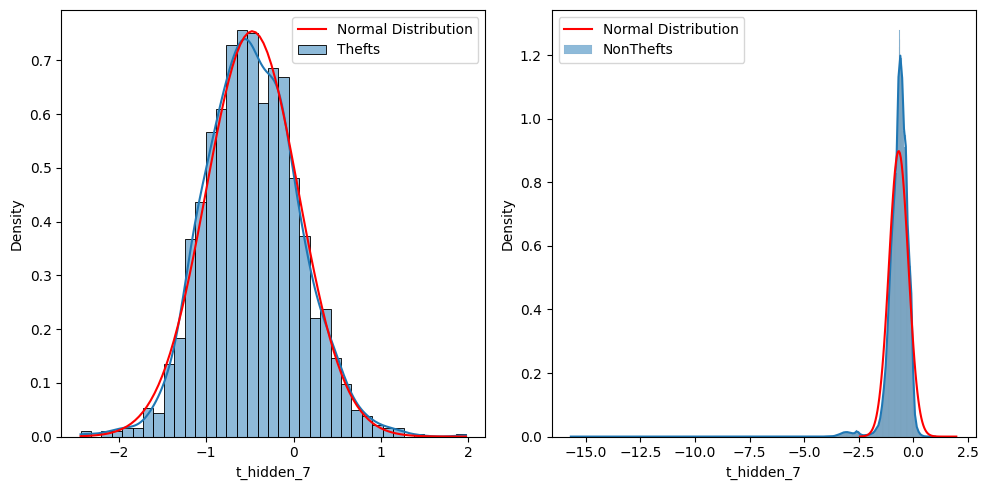

col: t_hidden_8
--
THEFTS:
min=-6.537523746490479, max=1.5625323057174685, mean=-1.1392302321001273
mode=-6.537523746490479, kurtosis=1.512002484833316, skew=-0.8024328510537286

NON-THEFTS:
min=-10.632052421569824, max=19.507699966430664, mean=0.1102907026893819
mode=-0.6388015151023865, kurtosis=8.29136342581447, skew=0.9818038036050648
--


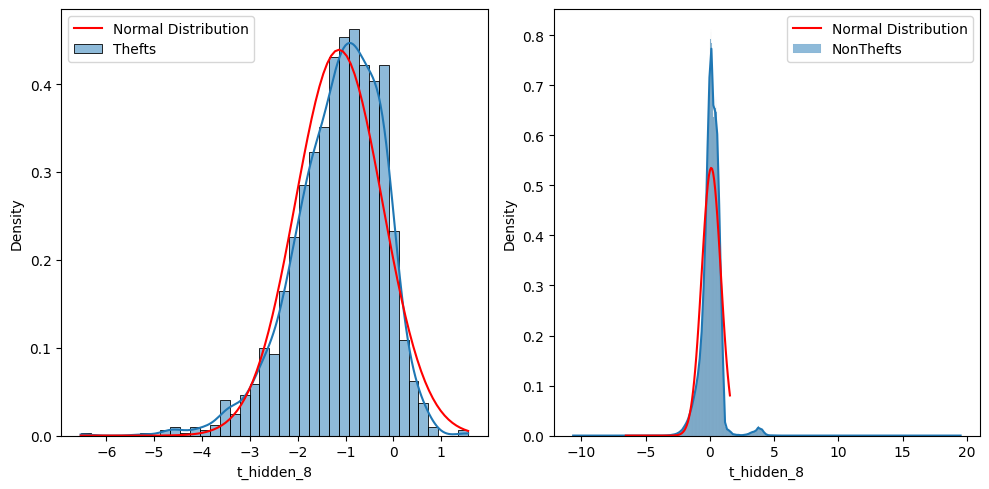

col: t_hidden_9
--
THEFTS:
min=-1.187293291091919, max=1.952946662902832, mean=0.18090803602940797
mode=-1.187293291091919, kurtosis=-0.006630085300893818, skew=0.21891697727162382

NON-THEFTS:
min=-6.101853370666504, max=10.519369125366213, mean=0.22217064079833088
mode=-0.0183935463428497, kurtosis=2.1422150888807345, skew=0.11618659819354321
--


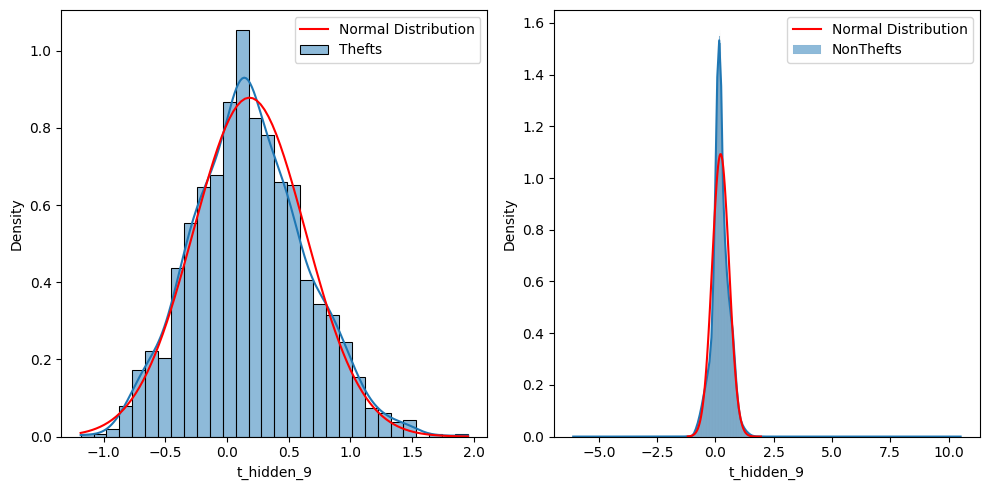

col: t_hidden_10
--
THEFTS:
min=-3.0093064308166504, max=1.2351784706115725, mean=-0.9458414777818126
mode=-3.0093064308166504, kurtosis=0.17777090586908129, skew=-0.5159361423518427

NON-THEFTS:
min=-11.349190711975098, max=13.137399673461914, mean=-0.23938904255457383
mode=-1.0457063913345337, kurtosis=10.323546631379246, skew=0.6792985207731527
--


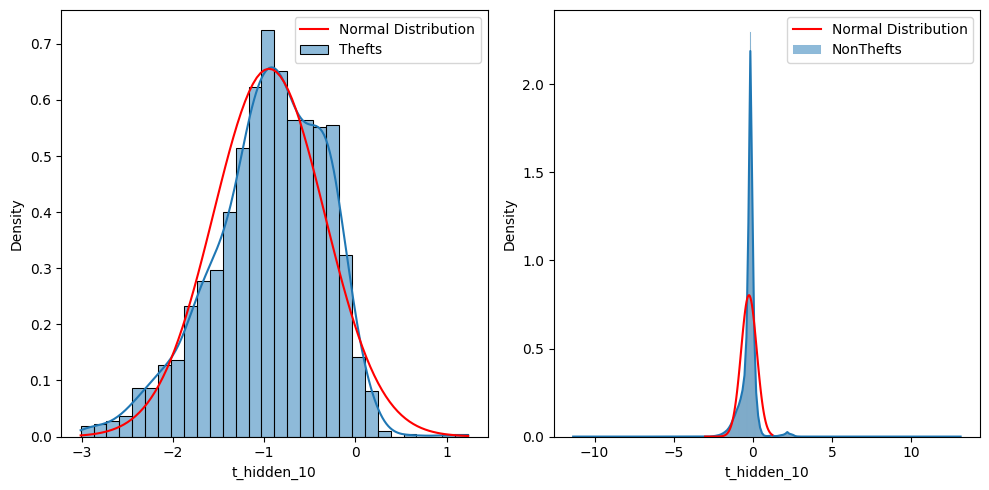

col: t_hidden_11
--
THEFTS:
min=-1.5647791624069214, max=3.289152145385742, mean=0.19892033328513434
mode=-1.5647791624069214, kurtosis=0.30132445236563443, skew=0.6038497161377199

NON-THEFTS:
min=-2.587714910507202, max=8.441036224365234, mean=-0.1917546399238703
mode=-0.5972933769226074, kurtosis=2.289234395609315, skew=1.3531671912569185
--


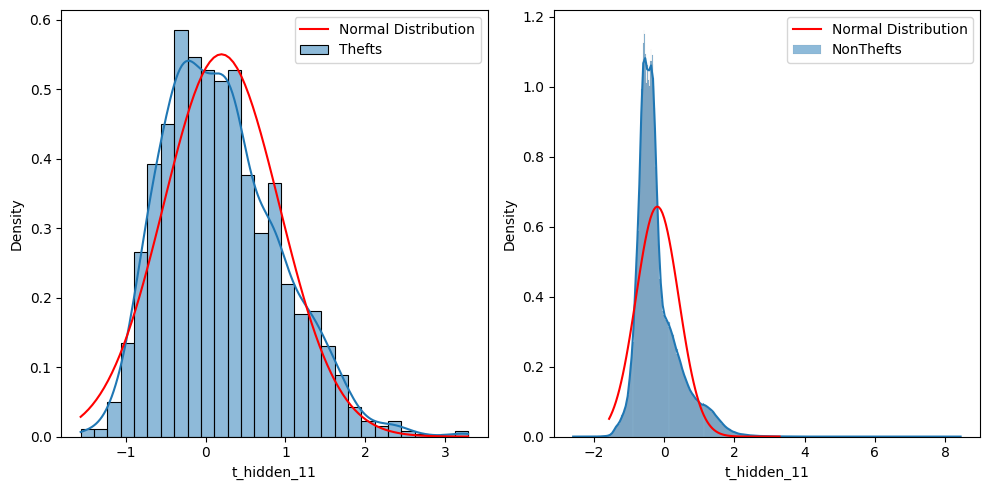

col: t_hidden_12
--
THEFTS:
min=-0.95229309797287, max=2.462934970855713, mean=0.42517073133590716
mode=-0.95229309797287, kurtosis=0.6046982857743721, skew=0.4942218184727647

NON-THEFTS:
min=-13.151223182678224, max=14.092257499694824, mean=0.11600529971213225
mode=0.0898500084877014, kurtosis=9.977474332043744, skew=-1.1278630342404552
--


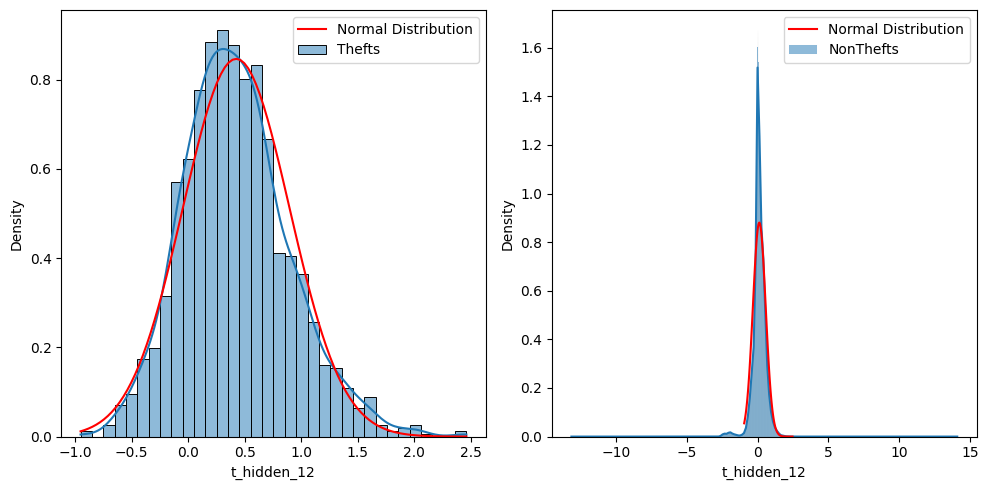

col: t_hidden_13
--
THEFTS:
min=-1.29285991191864, max=2.8744781017303467, mean=0.5581375803011134
mode=-1.29285991191864, kurtosis=0.5754910483643809, skew=0.6635956586410023

NON-THEFTS:
min=-2.2916955947875977, max=7.925915241241455, mean=0.1562426620169788
mode=-0.5788509249687195, kurtosis=1.9101703105201158, skew=0.8544052385892247
--


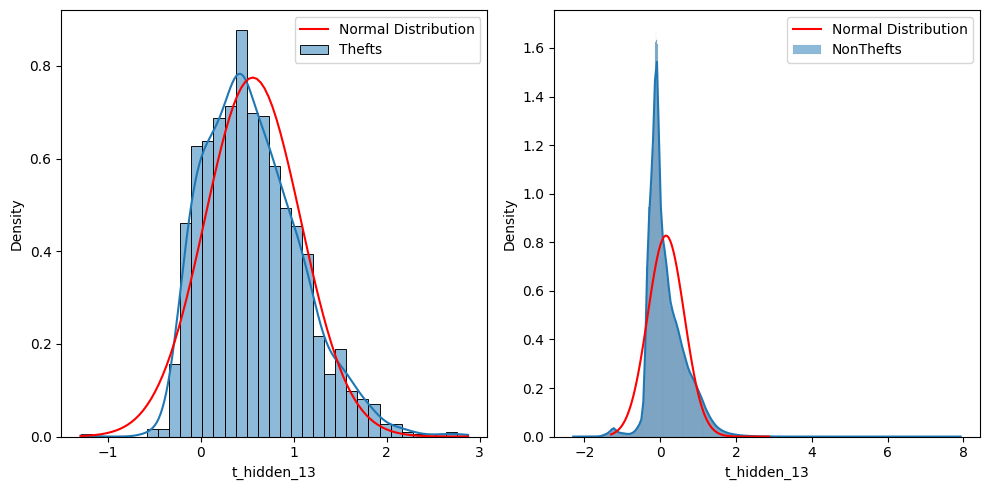

col: t_hidden_14
--
THEFTS:
min=-1.1241228580474854, max=2.501830101013184, mean=0.4791321233298975
mode=-1.1241228580474854, kurtosis=0.30559562683931274, skew=0.024910150432749696

NON-THEFTS:
min=-0.8392918705940247, max=16.857803344726562, mean=0.867369170969401
mode=0.7332481741905212, kurtosis=22.63667264504614, skew=3.7513555976119743
--


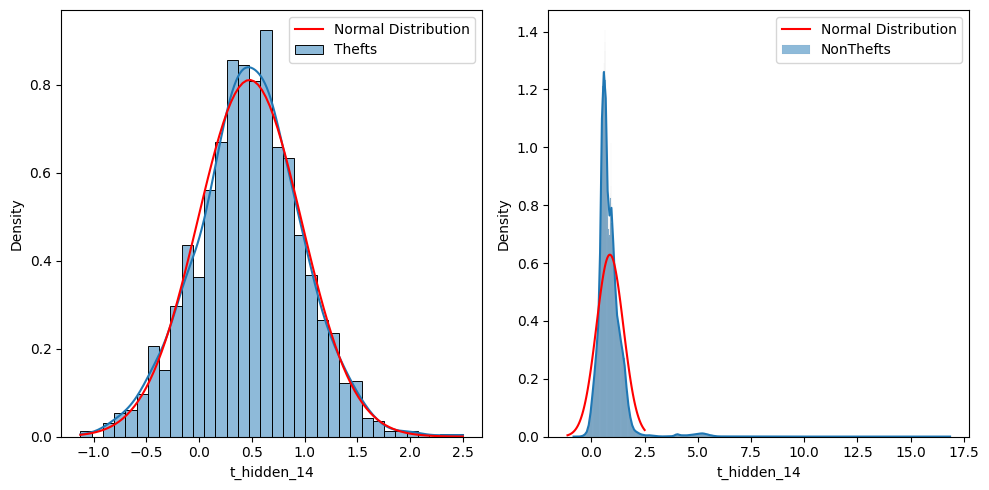

col: t_hidden_15
--
THEFTS:
min=-5.148218154907227, max=3.023998737335205, mean=-0.09842220882251475
mode=-5.148218154907227, kurtosis=0.5789481446185407, skew=-0.6284246687599258

NON-THEFTS:
min=-10.039956092834473, max=37.18650817871094, mean=1.285584021730923
mode=0.4927995800971985, kurtosis=26.697583996151884, skew=3.4895934277357585
--


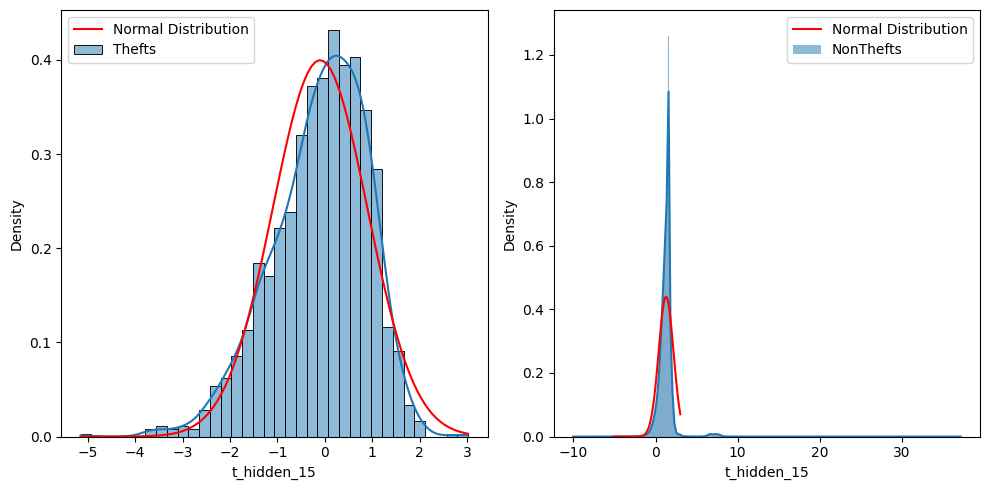

col: t_hidden_16
--
THEFTS:
min=-2.2583203315734863, max=2.9804701805114746, mean=0.6473135136874374
mode=-2.2583203315734863, kurtosis=0.5183207028514967, skew=-0.2661964769797734

NON-THEFTS:
min=-2.1866581439971924, max=26.02872085571289, mean=1.3388854240654728
mode=1.1188945770263672, kurtosis=28.333603206536967, skew=3.6131661326187143
--


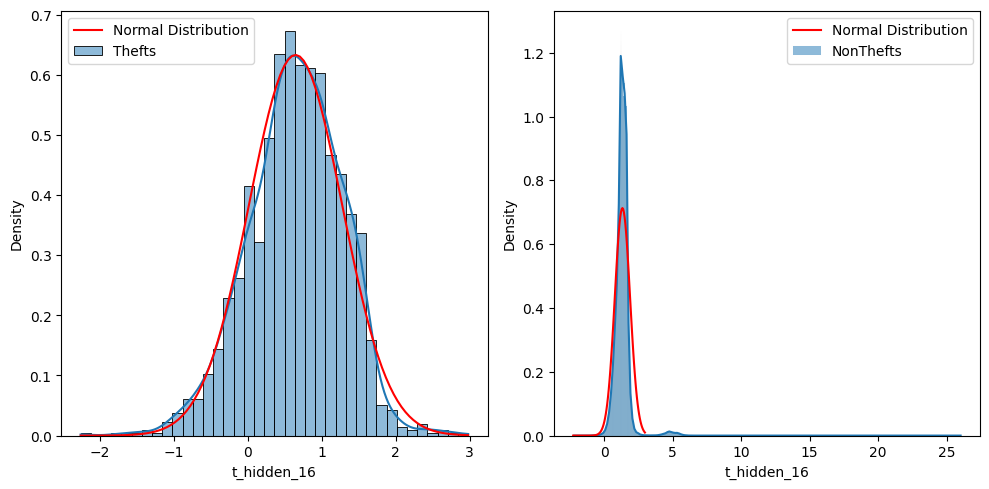

col: t_hidden_17
--
THEFTS:
min=-1.948019027709961, max=1.776153326034546, mean=-0.06401846819970104
mode=-1.948019027709961, kurtosis=0.7977089725434365, skew=-0.2951209272486238

NON-THEFTS:
min=-5.611782073974609, max=18.089614868164062, mean=0.07477317735885458
mode=0.037903469055891, kurtosis=11.42946363712894, skew=1.530396895891257
--


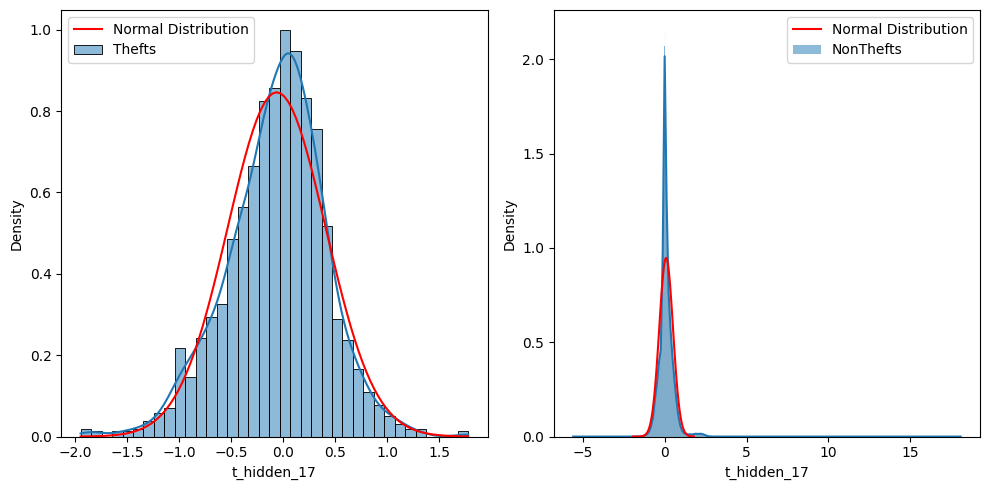

col: t_hidden_18
--
THEFTS:
min=-2.129643440246582, max=2.1616780757904053, mean=0.10181989325642508
mode=-2.129643440246582, kurtosis=1.8698831390926336, skew=-0.7345999500658805

NON-THEFTS:
min=-5.3704376220703125, max=4.448713779449463, mean=-0.4320591356002997
mode=-1.1579900979995728, kurtosis=-0.36225795905415437, skew=-0.4630178400410673
--


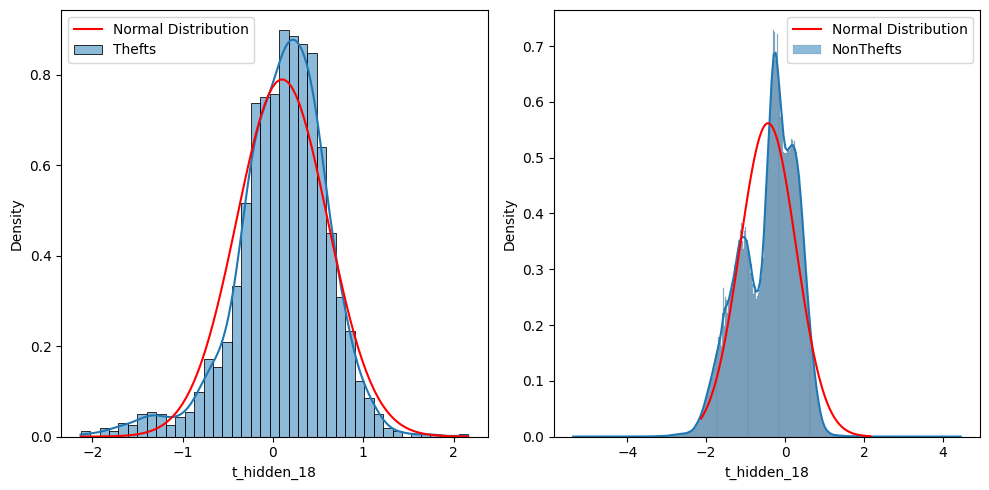

col: t_hidden_19
--
THEFTS:
min=-2.349630832672119, max=2.3567802906036377, mean=0.12497862244802575
mode=-2.349630832672119, kurtosis=0.17981037302967628, skew=-0.5129992399490874

NON-THEFTS:
min=-9.38312816619873, max=29.6749324798584, mean=0.9169962046672013
mode=0.9038098454475404, kurtosis=36.025228471213765, skew=4.399085130658522
--


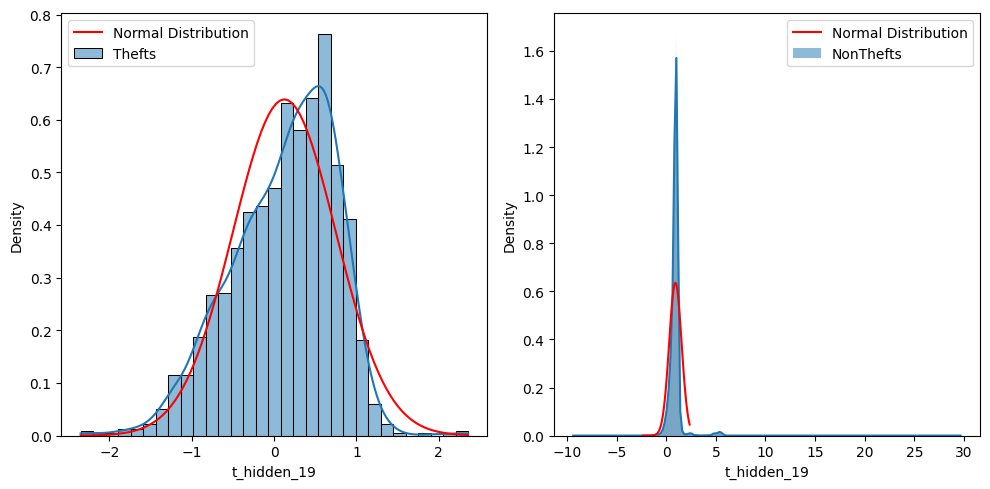

col: t_hidden_20
--
THEFTS:
min=-2.631483554840088, max=1.9762024879455569, mean=-0.049546726919307386
mode=-2.631483554840088, kurtosis=0.29066599527040893, skew=-0.5231052827577617

NON-THEFTS:
min=-15.646906852722168, max=7.793017387390137, mean=-0.05289329226016251
mode=0.355033814907074, kurtosis=1.5922729210065119, skew=-0.7753283238827596
--


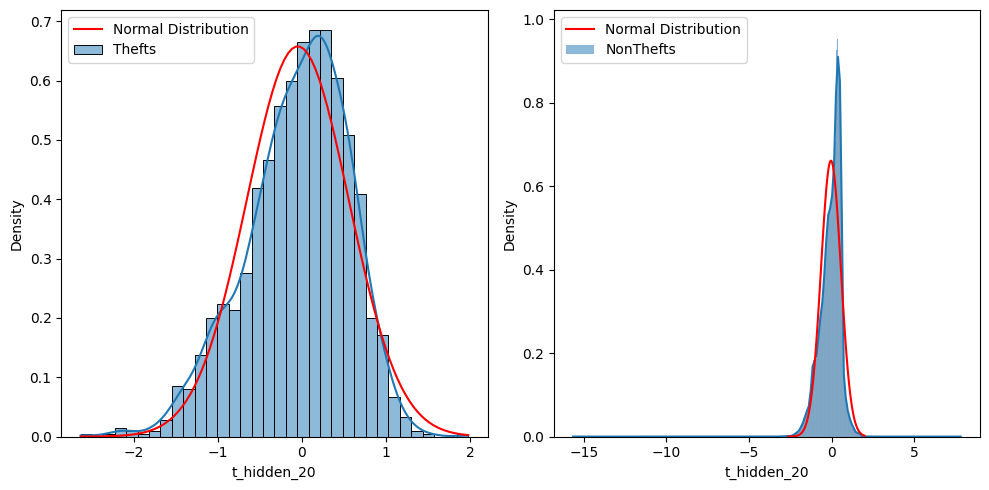

col: t_hidden_21
--
THEFTS:
min=-1.7775298357009888, max=3.777452230453491, mean=0.85083617787981
mode=-1.7775298357009888, kurtosis=0.27230939022884915, skew=0.41698580925737116

NON-THEFTS:
min=-2.333880662918091, max=9.542816162109377, mean=0.5028278955839102
mode=0.4733293056488037, kurtosis=1.7052062991157038, skew=0.7721394616171032
--


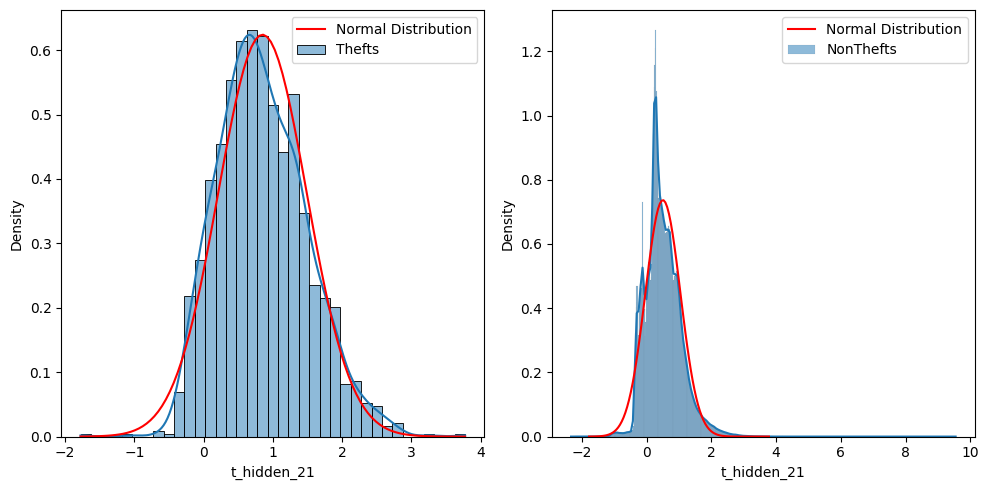

col: t_hidden_22
--
THEFTS:
min=-3.7434234619140634, max=1.0323646068572998, mean=-1.0021787019099646
mode=-3.7434234619140634, kurtosis=0.12636932213791008, skew=-0.22524898258028597

NON-THEFTS:
min=-17.007156372070312, max=0.6829326152801514, mean=-1.6397973618363617
mode=-2.330195903778076, kurtosis=1.7164445098341115, skew=-0.7940656424501864
--


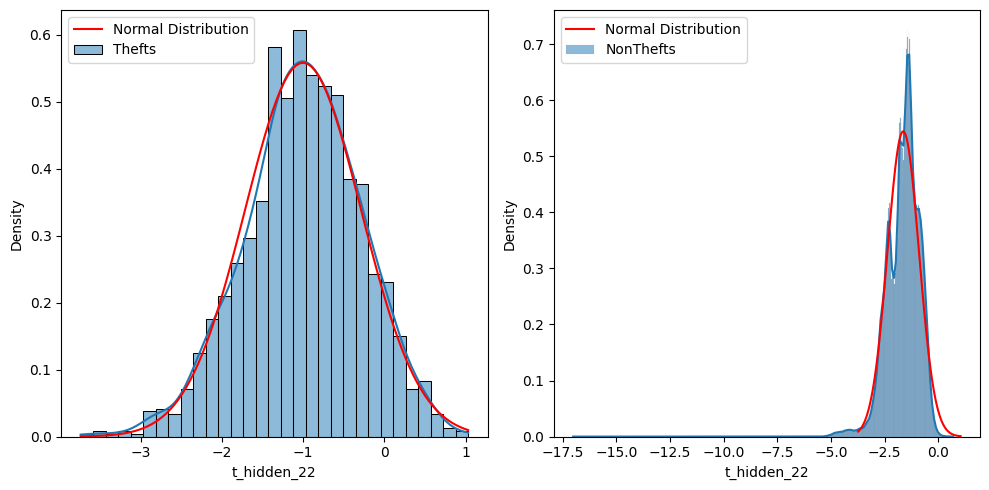

col: t_hidden_23
--
THEFTS:
min=-3.848027467727661, max=0.8169258236885071, mean=-0.6307446657579162
mode=-3.848027467727661, kurtosis=1.6234430773645614, skew=-0.8064465022128464

NON-THEFTS:
min=-3.4232754707336426, max=12.88497829437256, mean=-0.0958587519555829
mode=-1.0278215408325195, kurtosis=5.444434392008597, skew=1.022915443451992
--


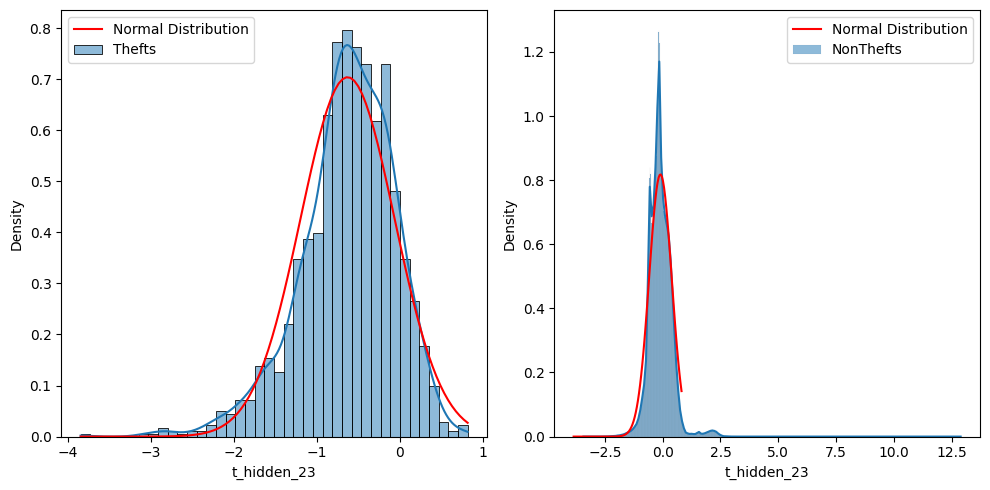

col: t_hidden_24
--
THEFTS:
min=-3.395435094833374, max=3.365353584289551, mean=0.45500479200158805
mode=-3.395435094833374, kurtosis=1.3218205871064899, skew=-0.5333840926581038

NON-THEFTS:
min=-2.805823802947998, max=26.565879821777344, mean=1.2044615271504577
mode=0.7864847183227539, kurtosis=13.403131784070734, skew=1.8242557346249124
--


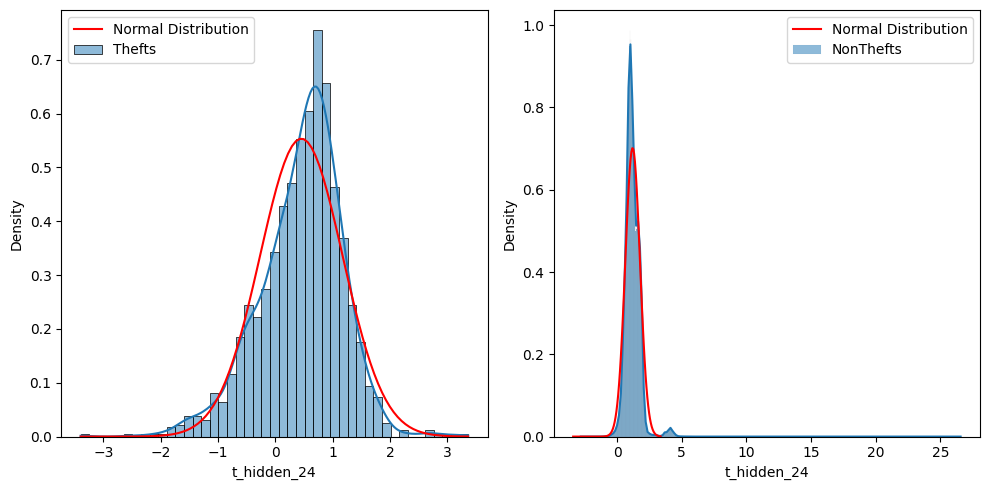

col: t_hidden_25
--
THEFTS:
min=-1.994417428970337, max=3.53350830078125, mean=0.6787692237376552
mode=-1.994417428970337, kurtosis=0.25279817094676194, skew=-0.08694442312218069

NON-THEFTS:
min=-2.8319787979125977, max=32.6690673828125, mean=1.426107915780982
mode=0.4925918281078338, kurtosis=36.12407984760748, skew=4.192076846424504
--


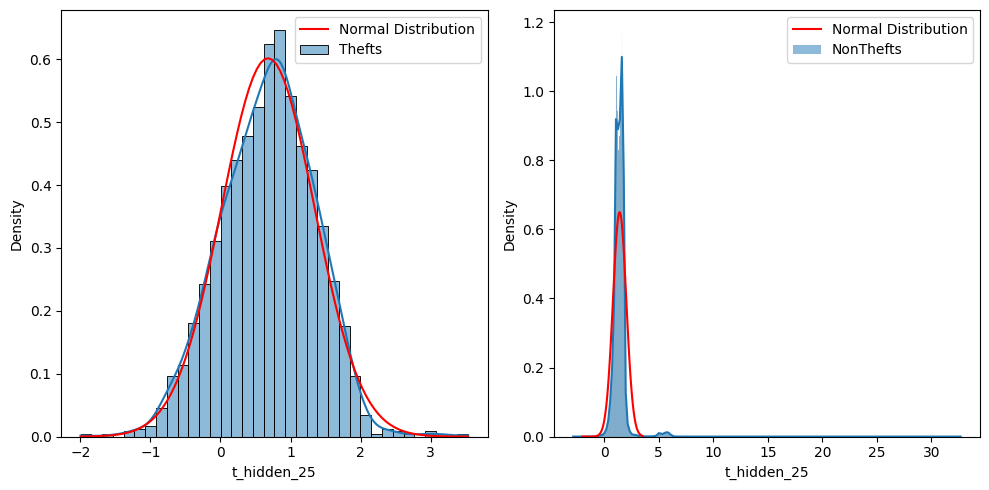

col: t_hidden_26
--
THEFTS:
min=-1.5069183111190796, max=1.942263126373291, mean=0.21446191949635438
mode=-1.5069183111190796, kurtosis=0.06770062446429925, skew=0.015386986699793784

NON-THEFTS:
min=-17.849960327148438, max=8.409793853759766, mean=-0.2098598963891557
mode=0.3959752917289734, kurtosis=10.446331180219817, skew=-1.96540579737745
--


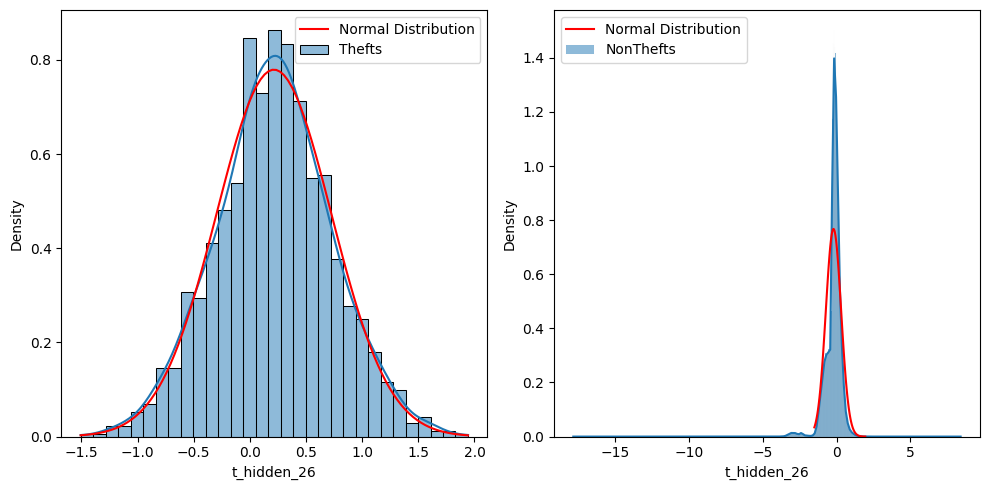

col: t_hidden_27
--
THEFTS:
min=-3.781423091888428, max=0.9569647908210754, mean=-0.8968205056861331
mode=-3.781423091888428, kurtosis=1.07974981423926, skew=-0.667021474347345

NON-THEFTS:
min=-14.92502784729004, max=0.7890849113464355, mean=-0.8812563939915181
mode=-0.8145467638969421, kurtosis=10.076196645488057, skew=-1.9885131260623414
--


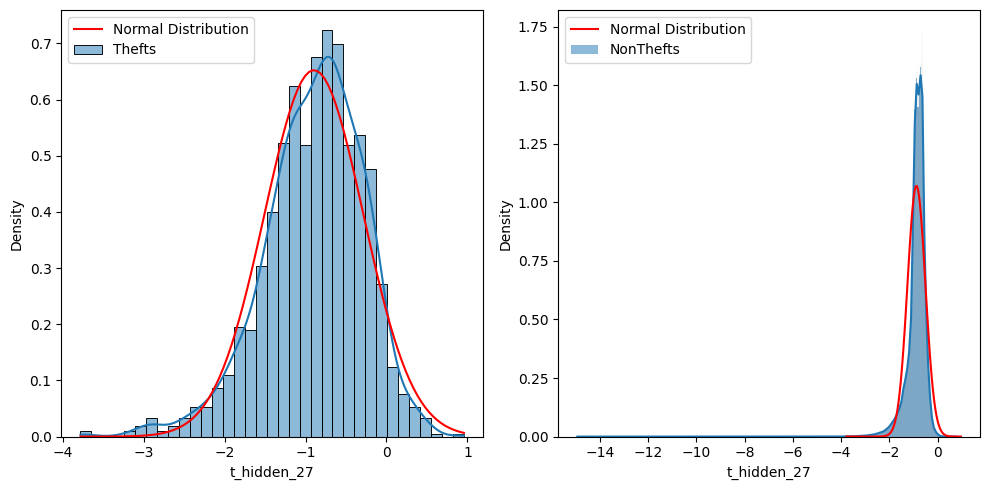

col: t_hidden_28
--
THEFTS:
min=-1.9884421825408936, max=1.4477691650390625, mean=-0.05092875320781214
mode=-1.9884421825408936, kurtosis=0.7821713612355246, skew=-0.4283458689000317

NON-THEFTS:
min=-4.014747619628906, max=18.0689697265625, mean=0.3473087027849297
mode=0.6012773513793945, kurtosis=17.573768928917612, skew=1.5236566057790504
--


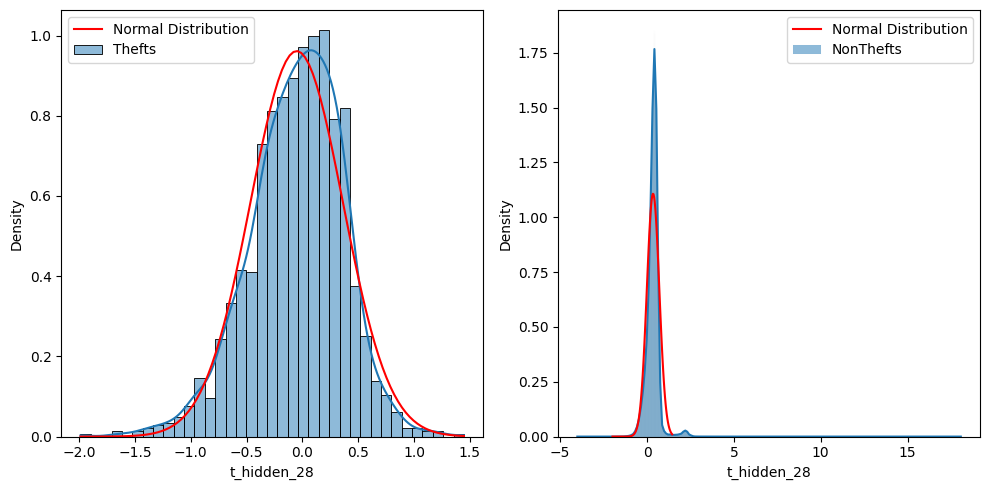

col: t_hidden_29
--
THEFTS:
min=-2.0346755981445312, max=2.098602771759033, mean=0.07361602366508282
mode=-2.0346755981445312, kurtosis=0.9144546601154393, skew=0.37289680875336884

NON-THEFTS:
min=-14.82608127593994, max=10.766826629638672, mean=-0.5850073311735277
mode=-1.1453181505203247, kurtosis=3.1360699151175857, skew=-0.3506444810748944
--


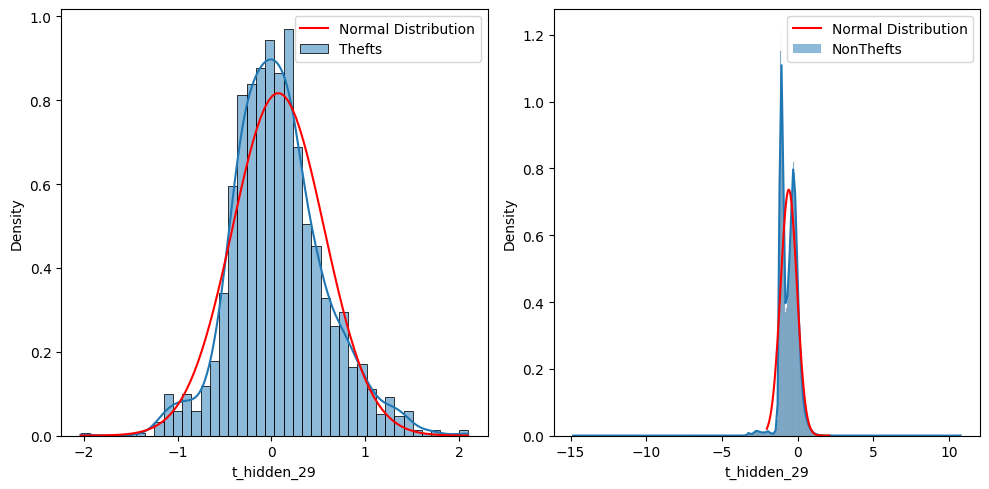

col: t_hidden_30
--
THEFTS:
min=-4.08822774887085, max=1.2494534254074097, mean=-1.317555883996544
mode=-4.08822774887085, kurtosis=0.4079792415674408, skew=-0.5554117069957194

NON-THEFTS:
min=-11.410346031188965, max=8.868741989135742, mean=-0.2658914244587376
mode=-0.0576244592666626, kurtosis=3.1005171174219934, skew=-0.4275002288947738
--


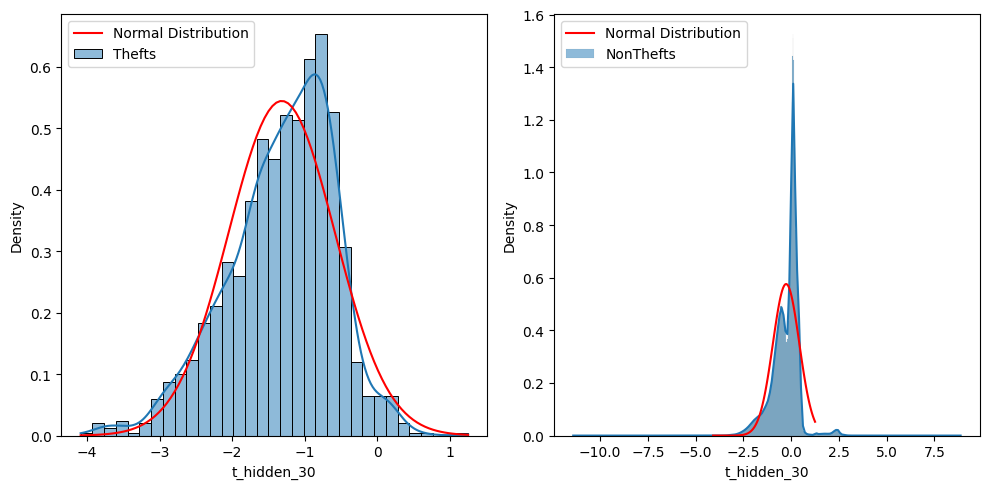

col: t_hidden_31
--
THEFTS:
min=-2.2792153358459477, max=2.4756791591644287, mean=-0.1964838926286734
mode=-2.2792153358459477, kurtosis=2.3103888690597194, skew=0.07114032875800809

NON-THEFTS:
min=-11.359862327575684, max=1.189972162246704, mean=-0.39576342466680714
mode=-0.5534727573394775, kurtosis=5.263759219503546, skew=-1.136469572651611
--


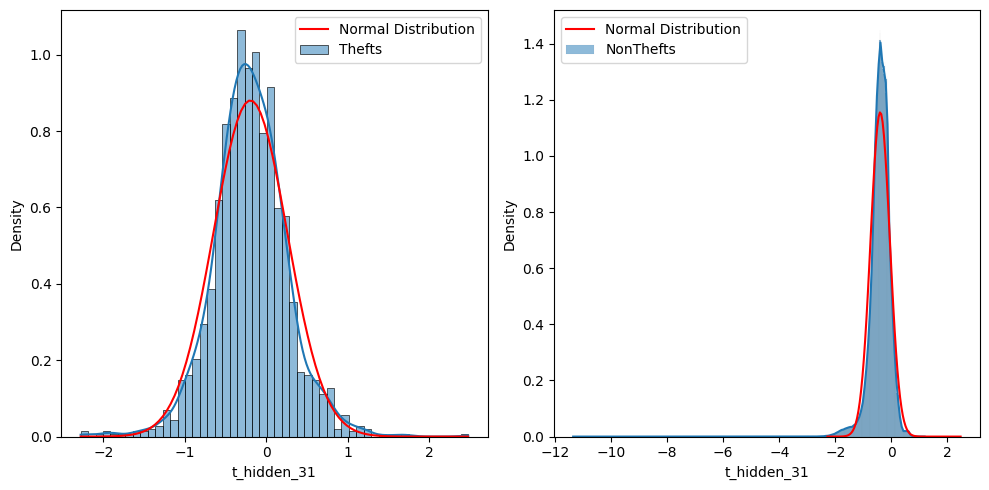

col: t_hidden_32
--
THEFTS:
min=-2.4612877368927, max=3.536210298538208, mean=0.04103667519088911
mode=-2.4612877368927, kurtosis=0.04855239368308739, skew=0.36097624944542317

NON-THEFTS:
min=-29.25557518005371, max=7.678669452667236, mean=-1.151874161966675
mode=-0.4112338423728943, kurtosis=23.23237346530106, skew=-3.335901453812522
--


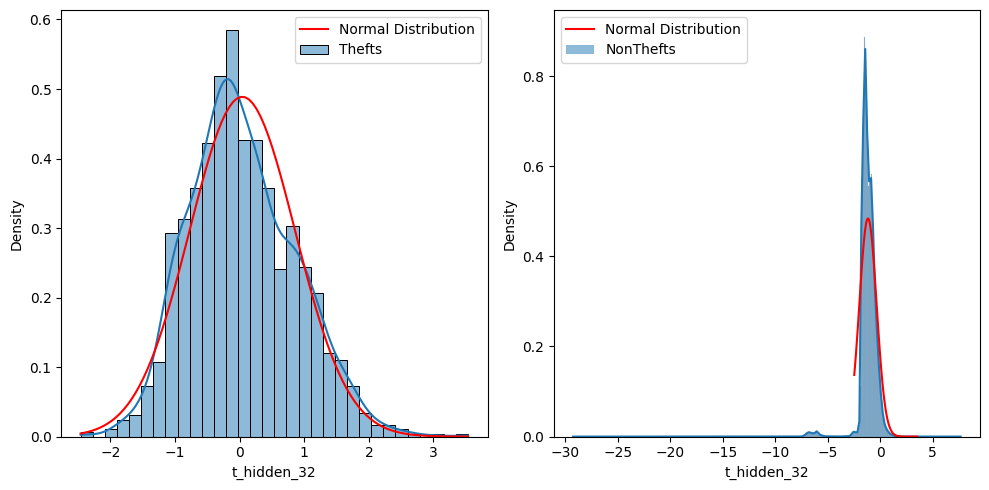

In [13]:
for col in df.columns:
    if col == 'auto_loss' or str(col).startswith('t_hidden'):
        plot_dist(thefts, non_thefts, col)

In [14]:
dfs = []

col: COUNT(consumptions)
--
THEFTS:
min=1.0, max=114.0, mean=12.473582474226804
mode=10.0, kurtosis=28.826774542722895, skew=3.7307841762317877

NON-THEFTS:
min=1.0, max=117.0, mean=12.94368260590271
mode=14.0, kurtosis=19.403132719448454, skew=2.5135616219109247
--


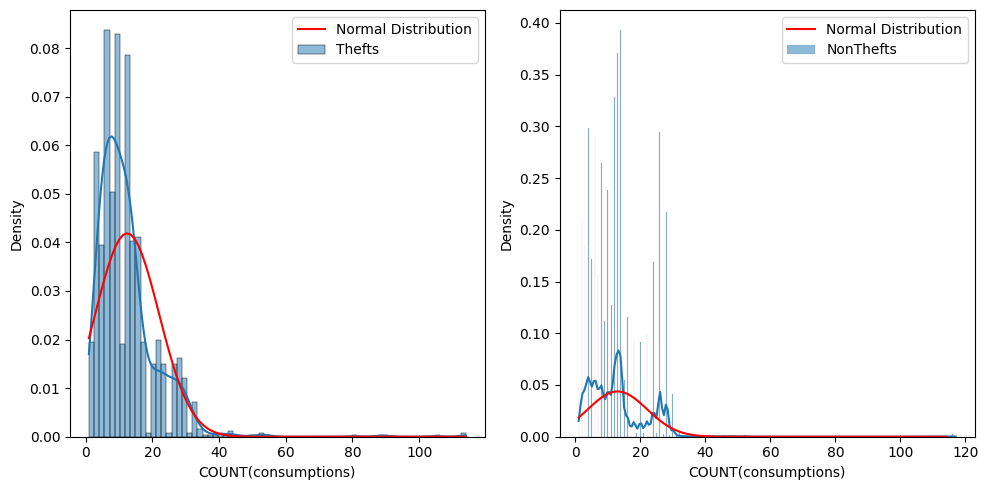

In [15]:
plot_dist(thefts, non_thefts, 'COUNT(consumptions)')

cap = 40.0
cap = 40.0
col: COUNT(consumptions)
--
THEFTS:
min=1.0, max=40.0, mean=12.205541237113403
mode=10.0, kurtosis=1.1727520574468557, skew=1.1955023713925212

NON-THEFTS:
min=1.0, max=40.0, mean=12.792146124209012
mode=14.0, kurtosis=-0.09296245351069254, skew=0.7729951566792169
--


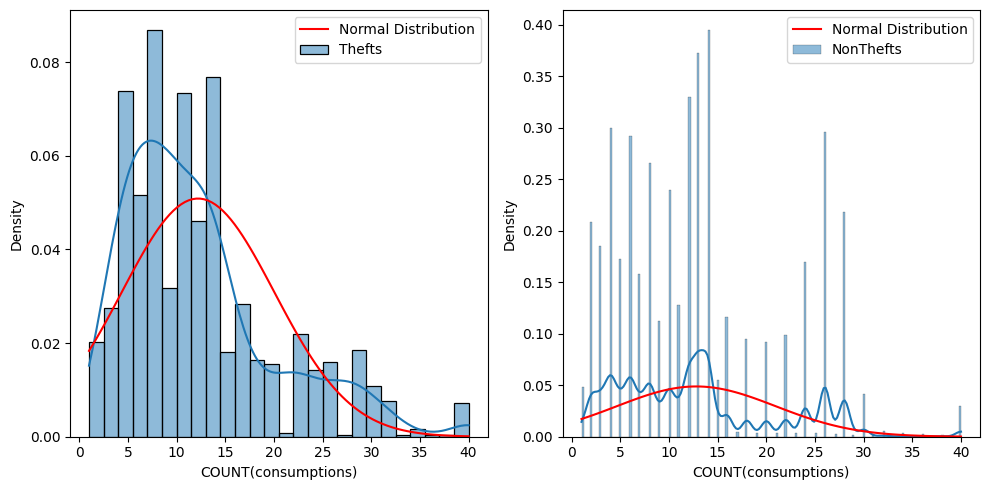

In [16]:
tmp_non_thefts, val = cap_values(non_thefts, 'COUNT(consumptions)', percentile=0.9935)

tmp_thefts, val = cap_values(thefts, 'COUNT(consumptions)', val=val)

plot_dist(tmp_thefts, tmp_non_thefts, 'COUNT(consumptions)')

In [17]:
#dfs.append(pd.concat([tmp_thefts, tmp_non_thefts]))

cap = 4063.0
cap = 4063.0
col: MAX(consumptions.CSS_MS_HS_USE)
--
THEFTS:
min=0.0, max=4063.0, mean=2054.666237113402
mode=4063.0, kurtosis=-1.3766376303256982, skew=0.14911441572898246

NON-THEFTS:
min=0.0, max=4063.0, mean=1743.731131798783
mode=4063.0, kurtosis=-0.7282443873741147, skew=0.5579980773188796
--


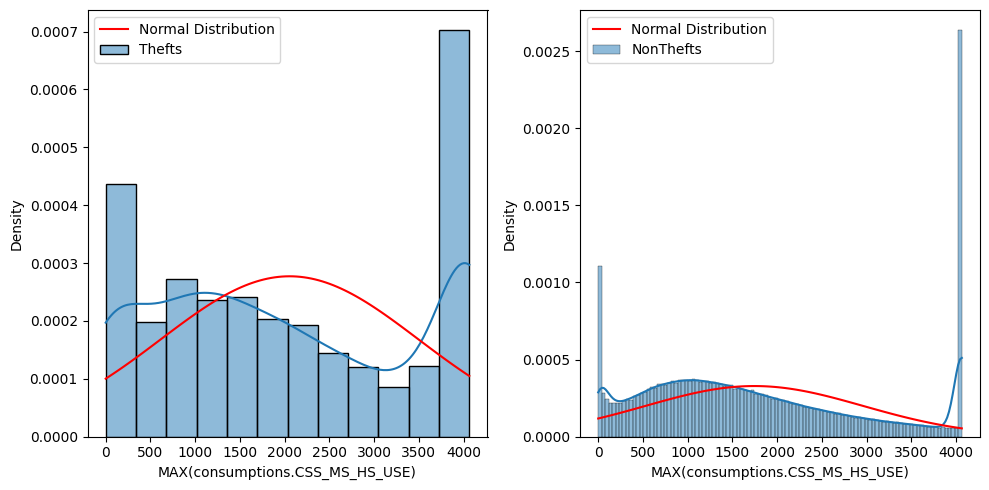

In [18]:
tmp_non_thefts, val = cap_values(tmp_non_thefts, 'MAX(consumptions.CSS_MS_HS_USE)', percentile=0.9)

tmp_thefts, val = cap_values(tmp_thefts, 'MAX(consumptions.CSS_MS_HS_USE)', val=val)

plot_dist(tmp_thefts, tmp_non_thefts, 'MAX(consumptions.CSS_MS_HS_USE)')

In [19]:
#dfs.append(pd.concat([tmp_thefts, tmp_non_thefts]))

cap = 2383.594999999999
cap = 2383.594999999999
col: MEAN(consumptions.CSS_MS_HS_USE)
--
THEFTS:
min=0.0, max=2383.594999999999, mean=846.6089978800309
mode=2383.594999999999, kurtosis=-0.3711726857687876, skew=0.8606865683359756

NON-THEFTS:
min=0.0, max=2383.594999999999, mean=790.362292678518
mode=2383.594999999999, kurtosis=0.5465905853608963, skew=1.0513093939038833
--


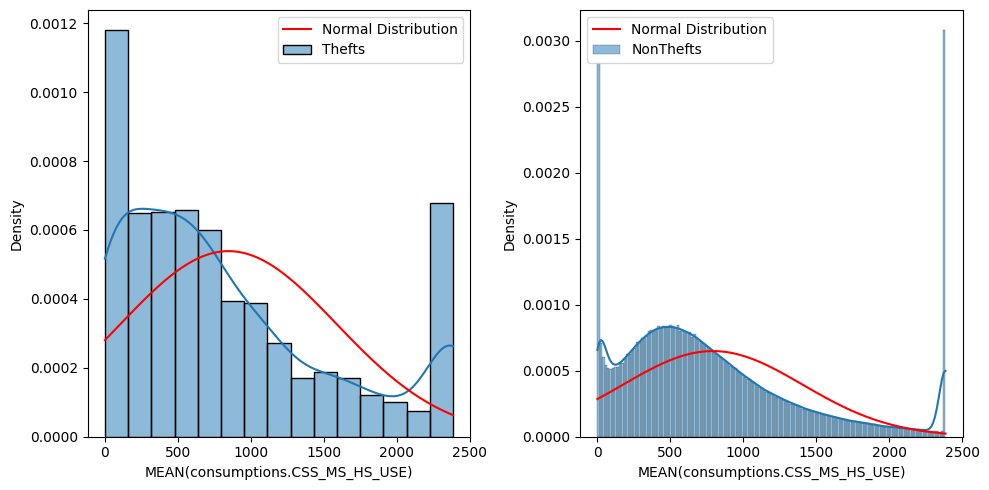

In [20]:
tmp_non_thefts, val = cap_values(tmp_non_thefts, 'MEAN(consumptions.CSS_MS_HS_USE)', percentile=0.95)

tmp_thefts, val = cap_values(tmp_thefts, 'MEAN(consumptions.CSS_MS_HS_USE)', val=val)

plot_dist(tmp_thefts, tmp_non_thefts, 'MEAN(consumptions.CSS_MS_HS_USE)')

cap = 889.0
cap = 889.0
col: MIN(consumptions.CSS_MS_HS_USE)
--
THEFTS:
min=0.0, max=889.0, mean=72.7673969072165
mode=0.0, kurtosis=9.496229151224224, skew=3.161311506562231

NON-THEFTS:
min=0.0, max=889.0, mean=181.68283910399202
mode=0.0, kurtosis=1.1345959986181415, skew=1.5207704115827494
--


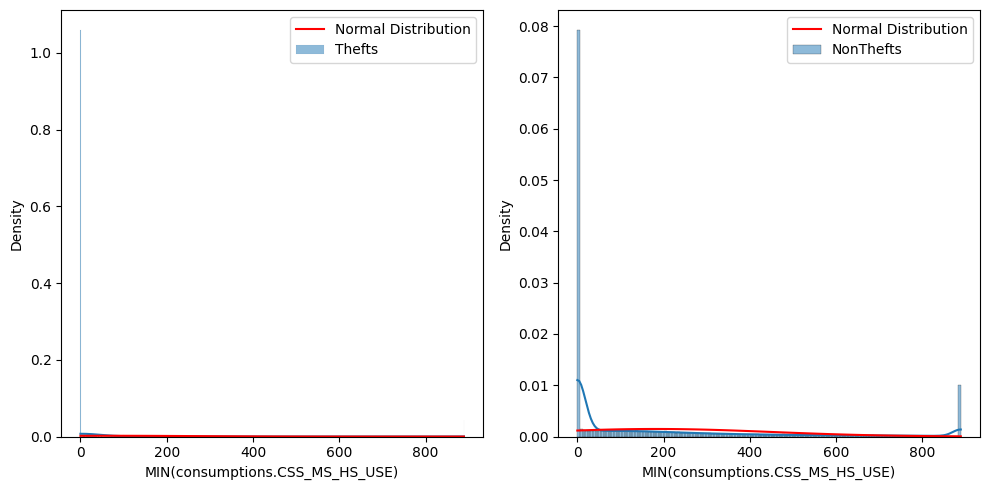

In [21]:
tmp_non_thefts, val = cap_values(tmp_non_thefts, 'MIN(consumptions.CSS_MS_HS_USE)', percentile=0.94)

tmp_thefts, val = cap_values(tmp_thefts, 'MIN(consumptions.CSS_MS_HS_USE)', val=val)

plot_dist(tmp_thefts, tmp_non_thefts, 'MIN(consumptions.CSS_MS_HS_USE)')

cap = 7994.640469122224
cap = 7994.640469122224
col: STD(consumptions.CSS_MS_HS_USE)
--
THEFTS:
min=0.0, max=7994.640469122224, mean=1029.1388065847782
mode=0.0, kurtosis=10.68575227958388, skew=3.1183062594357636

NON-THEFTS:
min=0.0, max=7994.640469122224, mean=628.9316532615668
mode=0.0, kurtosis=33.13652028157513, skew=5.078557024530572
--


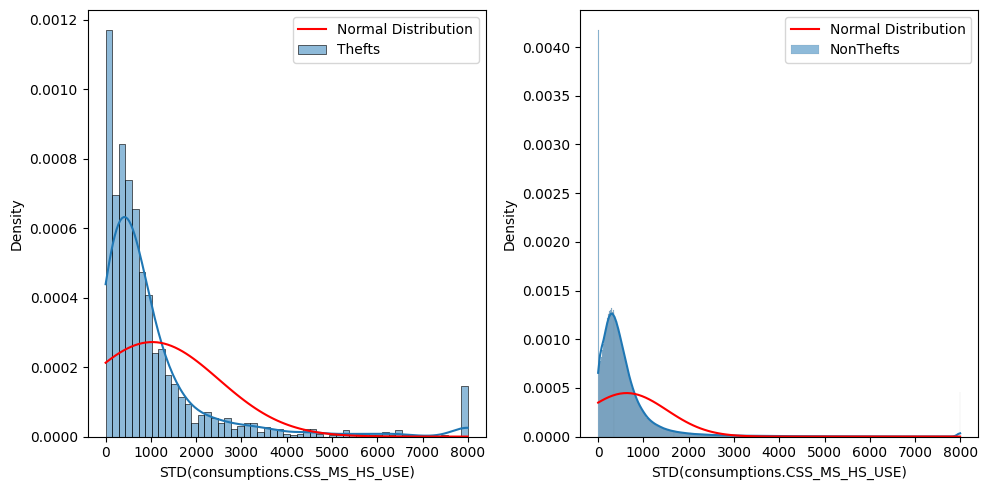

In [22]:
tmp_non_thefts, val = cap_values(tmp_non_thefts, 'STD(consumptions.CSS_MS_HS_USE)', percentile=0.995)

tmp_thefts, val = cap_values(tmp_thefts, 'STD(consumptions.CSS_MS_HS_USE)', val=val)

plot_dist(tmp_thefts, tmp_non_thefts, 'STD(consumptions.CSS_MS_HS_USE)')

cap = 89119.67999999993
cap = 89119.67999999993
col: SUM(consumptions.CSS_MS_HS_USE)
--
THEFTS:
min=0.0, max=89119.67999999993, mean=12678.374742268037
mode=0.0, kurtosis=8.688080133488564, skew=2.8591853428557084

NON-THEFTS:
min=0.0, max=89119.67999999993, mean=11183.856598666318
mode=0.0, kurtosis=13.338849018347112, skew=3.1096711601029883
--


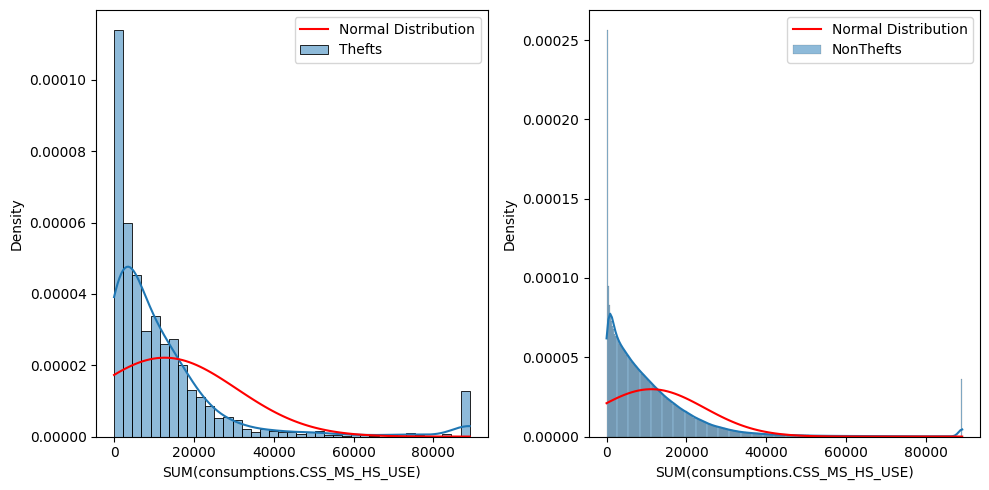

In [23]:
tmp_non_thefts, val = cap_values(tmp_non_thefts, 'SUM(consumptions.CSS_MS_HS_USE)', percentile=0.99)

tmp_thefts, val = cap_values(tmp_thefts, 'SUM(consumptions.CSS_MS_HS_USE)', val=val)

plot_dist(tmp_thefts, tmp_non_thefts, 'SUM(consumptions.CSS_MS_HS_USE)')

cap = 172.58367015098605
cap = 172.58367015098605
col: max_energy_per_day
--
THEFTS:
min=0.0, max=172.58367015098605, mean=26.966846983235076
mode=0.0, kurtosis=6.952264358379891, skew=2.720714598545486

NON-THEFTS:
min=0.0, max=172.58367015098605, mean=18.36159469689765
mode=172.58367015098605, kurtosis=20.15417648616409, skew=4.297012961861635
--


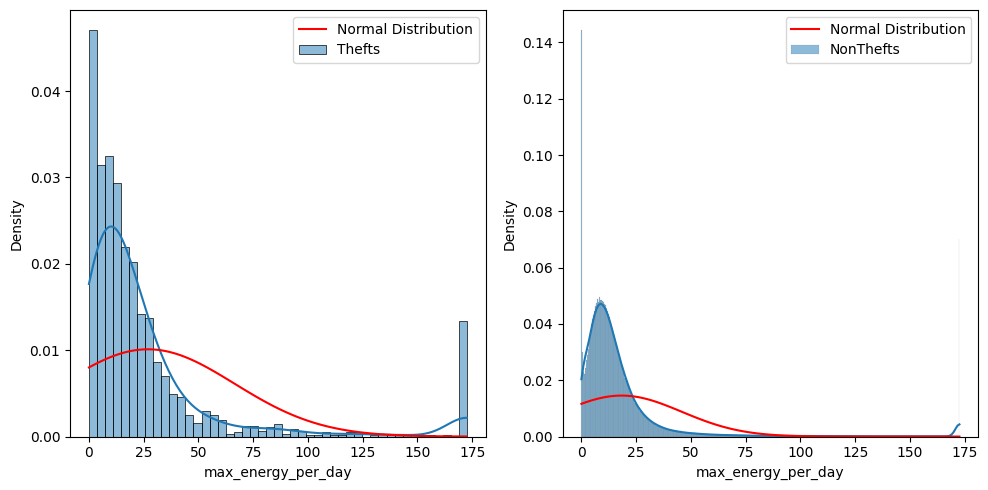

In [24]:
tmp_non_thefts, val = cap_values(tmp_non_thefts, 'max_energy_per_day', percentile=0.98)

tmp_thefts, val = cap_values(tmp_thefts, 'max_energy_per_day', val=val)

plot_dist(tmp_thefts, tmp_non_thefts, 'max_energy_per_day')

In [25]:
#tmp_non_thefts, val = cap_values(tmp_non_thefts, 'min_energy_per_day', percentile=0.96)

#tmp_thefts, val = cap_values(tmp_thefts, 'min_energy_per_day', val=val)

#plot_dist(tmp_thefts, tmp_non_thefts, 'min_energy_per_day')

cap = 55.790064901156526
cap = 55.790064901156526
col: mean_energy_per_day
--
THEFTS:
min=0.0, max=55.790064901156526, mean=12.226968276001859
mode=0.0, kurtosis=3.0935548981810777, skew=1.9368860753054136

NON-THEFTS:
min=0.0, max=55.790064901156526, mean=10.752482688973448
mode=55.790064901156526, kurtosis=7.513012078414453, skew=2.563479752544508
--


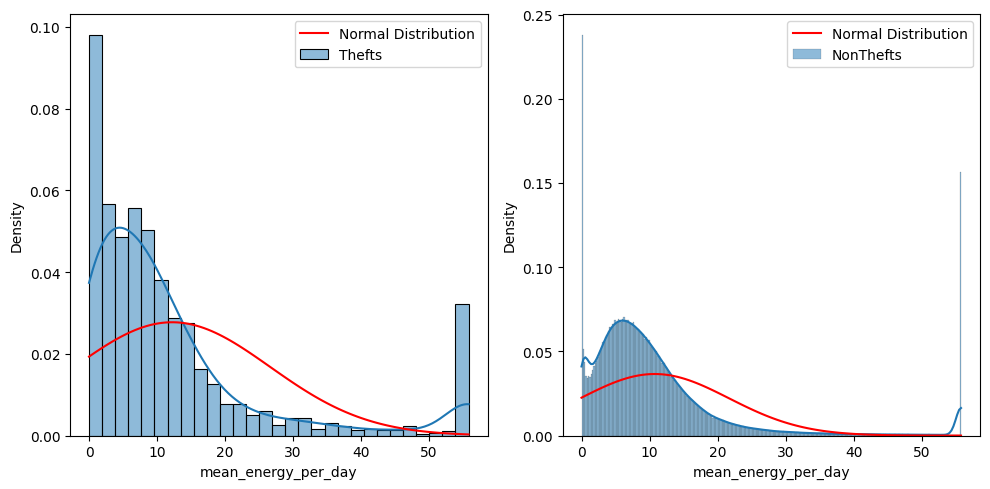

In [26]:
tmp_non_thefts, val = cap_values(tmp_non_thefts, 'mean_energy_per_day', percentile=0.97)

tmp_thefts, val = cap_values(tmp_thefts, 'mean_energy_per_day', val=val)

plot_dist(tmp_thefts, tmp_non_thefts, 'mean_energy_per_day')

cap = 51.98583456961802
cap = 51.98583456961802
col: median_energy_per_day
--
THEFTS:
min=0.0, max=51.98583456961802, mean=10.694284877871043
mode=0.0, kurtosis=3.509315487575963, skew=1.9883020152994941

NON-THEFTS:
min=0.0, max=51.98583456961802, mean=10.166110937859289
mode=0.0, kurtosis=7.122117901322925, skew=2.4825923281109117
--


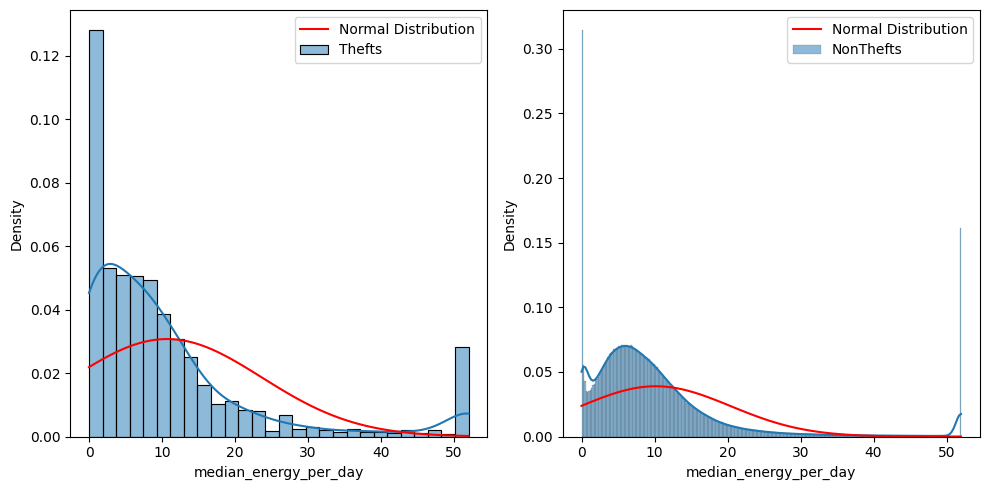

In [27]:
tmp_non_thefts, val = cap_values(tmp_non_thefts, 'median_energy_per_day', percentile=0.97)

tmp_thefts, val = cap_values(tmp_thefts, 'median_energy_per_day', val=val)

plot_dist(tmp_thefts, tmp_non_thefts, 'median_energy_per_day')

In [28]:
#tmp_non_thefts, val = cap_values(tmp_non_thefts, 'std_energy_per_day', percentile=0.99)

#tmp_thefts, val = cap_values(tmp_thefts, 'std_energy_per_day', val=val)

#plot_dist(tmp_thefts, tmp_non_thefts, 'std_energy_per_day')

cap = 666.0
cap = 666.0
col: max_measurement_interval_in_days
--
THEFTS:
min=0.0, max=666.0, mean=210.23324742268042
mode=246.0, kurtosis=3.01376079762781, skew=1.4393404517524395

NON-THEFTS:
min=0.0, max=666.0, mean=197.02165910550855
mode=246.0, kurtosis=2.8659425648590484, skew=1.1245323842362502
--


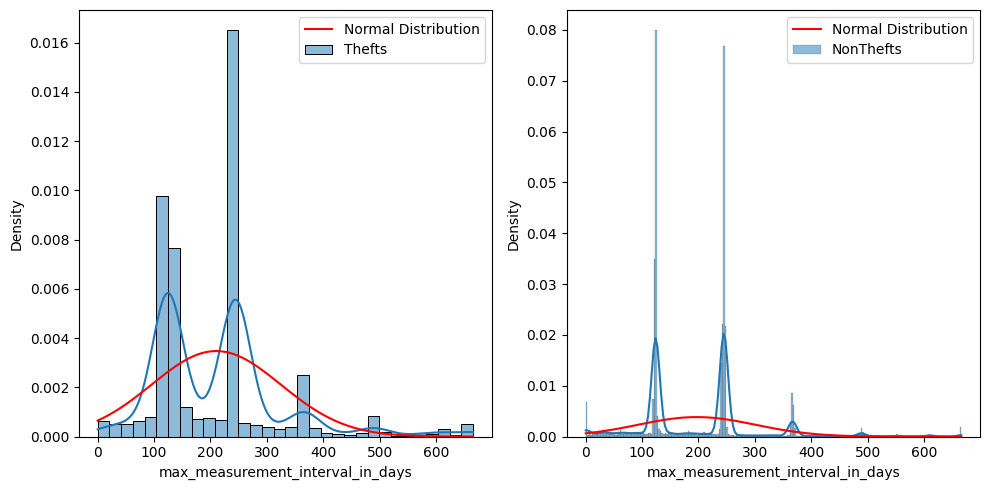

In [29]:
tmp_non_thefts, val = cap_values(tmp_non_thefts, 'max_measurement_interval_in_days', percentile=0.995)

tmp_thefts, val = cap_values(tmp_thefts, 'max_measurement_interval_in_days', val=val)

plot_dist(tmp_thefts, tmp_non_thefts, 'max_measurement_interval_in_days')

In [30]:
#tmp_non_thefts, val = cap_values(tmp_non_thefts, 'min_measurement_interval_in_days', percentile=0.995)

#tmp_thefts, val = cap_values(tmp_thefts, 'min_measurement_interval_in_days', val=val)

#plot_dist(tmp_thefts, tmp_non_thefts, 'min_measurement_interval_in_days')

In [31]:
#tmp_non_thefts, val = cap_values(tmp_non_thefts, 'mean_measurement_interval_in_days', percentile=0.995)

#tmp_thefts, val = cap_values(tmp_thefts, 'mean_measurement_interval_in_days', val=val)

#plot_dist(tmp_thefts, tmp_non_thefts, 'mean_measurement_interval_in_days')

In [32]:
#tmp_non_thefts, val = cap_values(tmp_non_thefts, 'median_measurement_interval_in_days', percentile=0.99)

#tmp_thefts, val = cap_values(tmp_thefts, 'median_measurement_interval_in_days', val=val)

#plot_dist(tmp_thefts, tmp_non_thefts, 'median_measurement_interval_in_days')

In [33]:
#tmp_non_thefts, val = cap_values(tmp_non_thefts, 'days_since_last_measurement', percentile=0.95)

#tmp_thefts, val = cap_values(tmp_thefts, 'days_since_last_measurement', val=val)

#plot_dist(tmp_thefts, tmp_non_thefts, 'days_since_last_measurement')

In [34]:
df.columns[79]

'MODE(consumptions.BS_RATE)_40'

700519
700519
Classifier: CATBOOST
Number of samples: 700519
Data bins [698967   1552]
bins [559174   1241]
bins [139793    311]
0.1 -- Lift: 0.7742, Demotion: 1.0000, Weighted: 0.8419
0.2 -- Lift: 0.5484, Demotion: 1.0000, Weighted: 0.6839
0.3 -- Lift: 0.3978, Demotion: 1.0000, Weighted: 0.5785
0.4 -- Lift: 0.3387, Demotion: 1.0000, Weighted: 0.5371
0.5 -- Lift: 0.2968, Demotion: 1.0000, Weighted: 0.5077
0.6 -- Lift: 0.2688, Demotion: 1.0000, Weighted: 0.4882
0.7 -- Lift: 0.2442, Demotion: 1.0000, Weighted: 0.4710
0.8 -- Lift: 0.2298, Demotion: 1.0000, Weighted: 0.4609
0.9 -- Lift: 0.2186, Demotion: 1.0000, Weighted: 0.4530
1 -- Lift: 0.2058, Demotion: 1.0000, Weighted: 0.4441
Fold 1 - Accuracy: 0.9979, Precision: 0.8000, Recall: 0.0643, F1: 0.1190, Brier: 0.0020, AUC-ROC: 0.8890, PR-AUC: 0.1503, Lift: 0.3387, Demotion: 1.0000, Weighted: 0.5371
bins [559174   1241]
bins [139793    311]
0.1 -- Lift: 0.5806, Demotion: 1.0000, Weighted: 0.7065
0.2 -- Lift: 0.3871, Demotion: 0.9839, Weigh

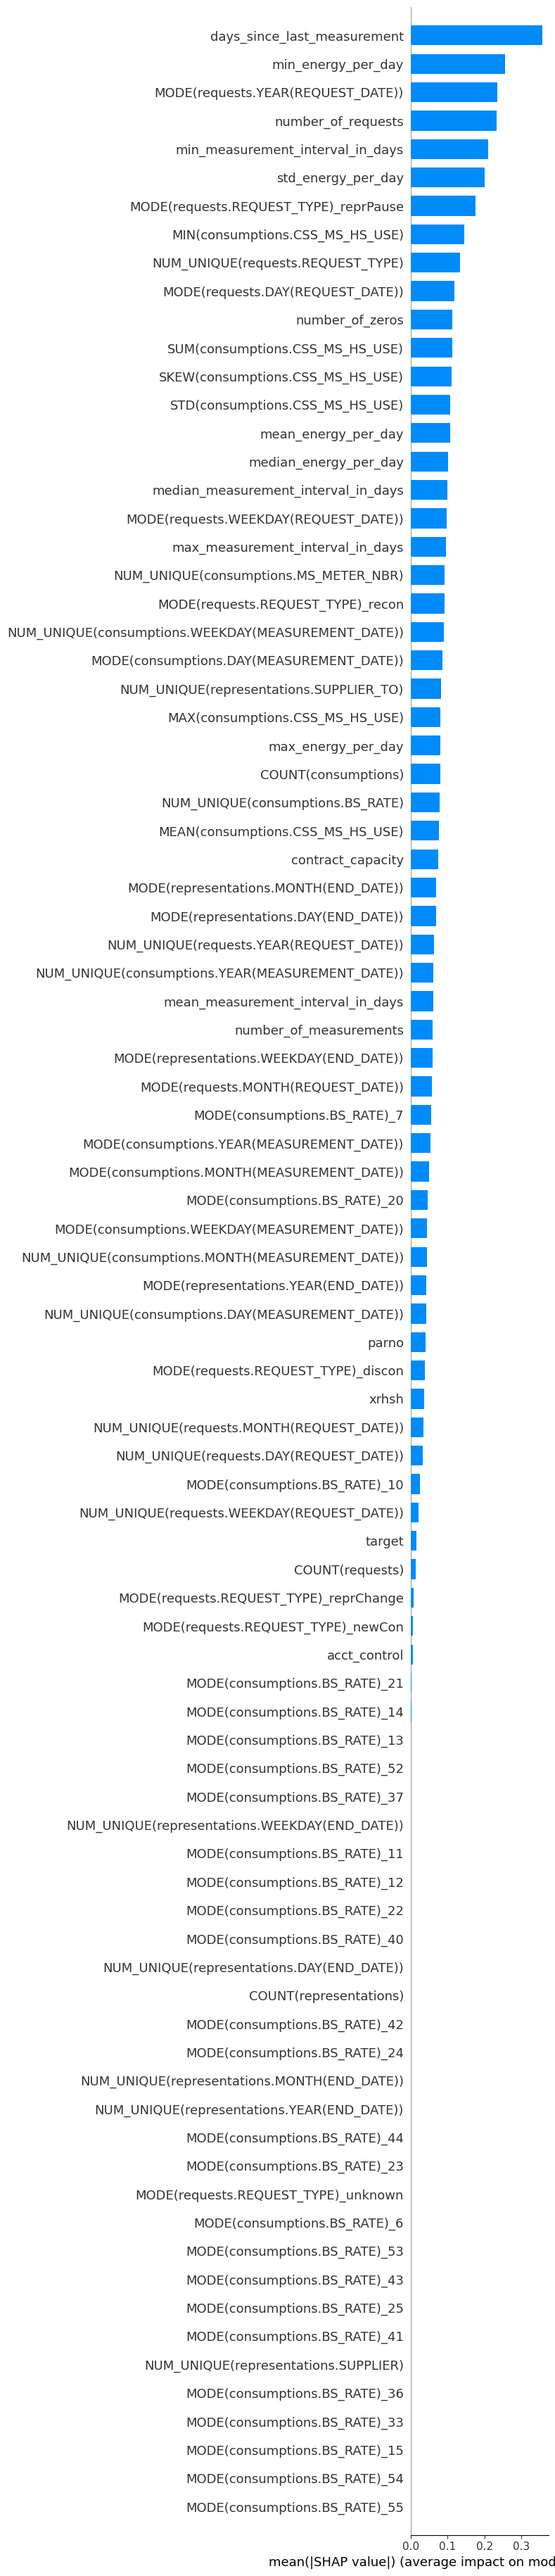

In [35]:
tmp_df = pd.concat([tmp_thefts, tmp_non_thefts])
print(len(tmp_df))
tmp_df = tmp_df.drop_duplicates()
print(len(tmp_df))

X = tmp_df.drop(['target'], axis=1)
y = tmp_df['target']
train(clf, X, y, list(df.columns))